In [1]:
from keras.models import Sequential
from keras.layers import Dense
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Kalman Filter  fabrication with DeepLearning and application to non-Gaussian distribution

# 1.도입

칼만 필터는 잡음이 포함되어 있는 역학적 상태를 추적하는 재귀 필터로서 시간에 따라 진행한 측정을 기반으로 한다.
고정되어 있지 않은 가변적인 이득 값을 사용함으로써 측정한 값과 그 동안 누적된 예측값을 이용해서 새로운 추정값을 얻을 수 있다.
주로 노이즈가 많은 현상에서 사용된다고 한다. 인공위성의 항법, 미사일의 궤적추정, 레이다 등에 많이 이용되어 왔고 최근의 고속의 고성능 마이크로 프로세서의 발달로
 칼만 필터는 매우 복잡한 실시간 처리 시스템에서도 점점 더 이용가치가 높아지고 있다.

##### Kalman Filter
위 상황은 드론이 가만히 떠 있는는 상태이고  초기 위치는 0 이다.
 드론은 스스로 운동하지 않고 바람에 의해서만 움직이는데, 문제의 간결화를 위해 위치는  1차원으로만 설정하였다. 드론에 달린 센서가 드론의 위치를 사용자에게 계속해서 송출하는데 정확한 위치를 송출하지 못하고 노이즈를 포함한채 송출한다. 센서의 노이즈는 n으로 표현된다. 여기서는 랜덤한 바람이 분다고 가정하고 바람백터를 w로 한다. 
 ##### A : drift matrix
 ##### B : input matrix
 ##### C : observation matrix
 ##### Xt+1 = AXt + Bw
 ##### Yt+1 = CXt + N
 ##### X = [Pt,Vt] :드론의 위치와 속력 벡터
 ##### Y = [P] : 드론의 위치(계측치)

# 데이터(Train) 생성
##### 칼민필터에 대한 예시를 보여줄 데이터와 훈련 데이터 생성

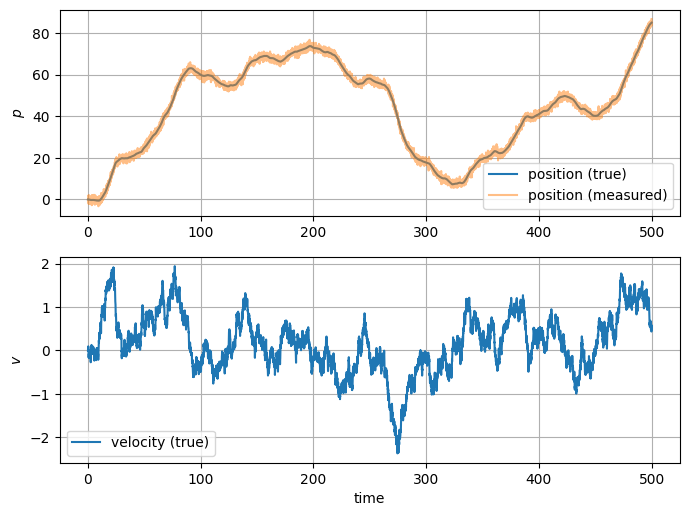

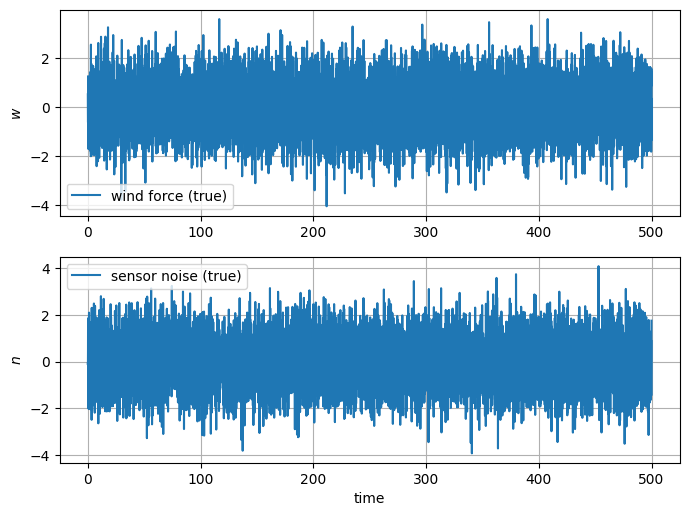

In [2]:
seed=221
epochs=200
batch_size=16
N = 10000 # number of timesteps
T = 500 # time will vary from 0 to T with step delt
ts = np.linspace(0,T,N+1)
delt = T/N
gamma = .05 # damping, 0 is no damping

A = np.zeros((2,2))
B = np.zeros((2,1))
C = np.zeros((1,2))

A[0,0] = 1
A[0,1] = (1-gamma*delt/2)*delt
A[1,1] = 1 - gamma*delt

B[0,0] = delt**2/269
B[1,0] = delt

C[0,0] = 1

np.random.seed(seed)

x = np.zeros((2,N+1))
x[:,0] = [0,0]
y = np.zeros((1,N))

w = np.random.randn(1,N)
n = np.random.randn(1,N)

for t in range(N):
    y[:,t] = C.dot(x[:,t]) + n[:,t]
    x[:,t+1] = A.dot(x[:,t]) + B.dot(w[:,t])
    
    
x_true = x.copy()
w_true = w.copy()
n_true = n.copy()

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts,x[0,:], label='position (true)')
plt.plot(ts[:-1],y[0,:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts[:-1],w_true[0,:], label='wind force (true)')
plt.ylabel(r"$w$")
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts[:-1],n_true[0,:], label='sensor noise (true)')
plt.xlabel('time')
plt.ylabel(r'$n$')
plt.legend()
plt.grid()
plt.show()

# Test 데이터 생성

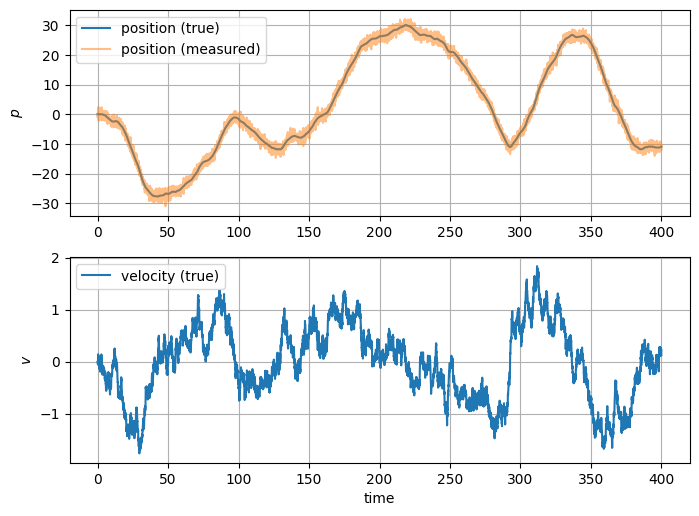

In [3]:
N_test = 8000 # number of timesteps
T_test = 400 # time will vary from 0 to T with step delt
ts_test = np.linspace(0,T_test,N_test+1)
delt_test = T_test/N_test
gamma_test = .05 # damping, 0 is no damping

A_test = np.zeros((2,2))
B_test= np.zeros((2,1))
C_test = np.zeros((1,2))

A_test[0,0] = 1
A_test[0,1] = (1-gamma_test*delt_test/2)*delt_test
A_test[1,1] = 1 - gamma_test*delt_test

B_test[0,0] = delt_test**2/269
B_test[1,0] = delt_test

C_test[0,0] = 1


x_test = np.zeros((2,N_test+1))
x_test[:,0] = [0,0]
y_test = np.zeros((1,N_test))

w_test = np.random.randn(1,N_test)
n_test = np.random.randn(1,N_test)

for t in range(N_test):
    y_test[:,t] = C_test.dot(x_test[:,t]) + n_test[:,t]
    x_test[:,t+1] = A_test.dot(x_test[:,t]) + B_test.dot(w_test[:,t])
    
plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts_test,x_test[0,:], label='position (true)')
plt.plot(ts_test[:-1],y_test[0,:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts_test,x_test[1,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()


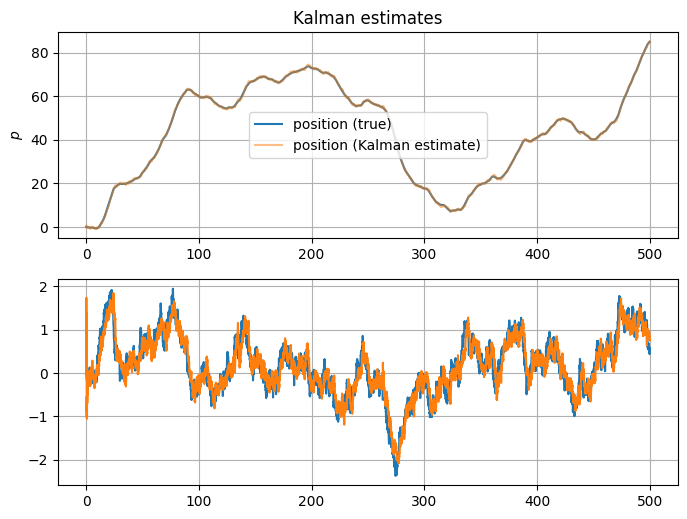

In [4]:
sigma_w = B@B.T
sigma_v = 1
hat_x = np.zeros((2,N))
hat_x[:,0] = np.array([0,0])
sigma = np.eye(2)*10

x_train = np.zeros((2,N))
y_train = np.zeros((2,N))

for t in range(N-1):
    K = A@sigma@C.T@np.linalg.inv(C@sigma@C.T+sigma_v)
    hat_x[:,t+1] = A@hat_x[:,t] + K@(y[0,t] - C@hat_x[:,t])
    sigma = A@sigma@A.T - K@C@sigma@A.T+sigma_w
    x_train[:,t] = (y[0,t] - C@hat_x[:,t])
    y_train[:,t] = hat_x[:,t+1]-A@hat_x[:,t]
x_train = x_train.reshape(-1,2)
y_train = y_train.reshape(-1,2)


plt.figure(figsize = (8,6),dpi=100)
plt.subplot(2,1,1)
plt.plot(ts,x[0,:],label='position (true)')
plt.plot(ts[:-1],hat_x[0,:],alpha = 0.5, label='position (Kalman estimate)')
plt.ylabel(r'$p$')
plt.title('Kalman estimates')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts,x[1,:],label='velocity (true)')
plt.plot(ts[:-1],hat_x[1,:],alpha=1,label='velocity (Kalman estimates)')
plt.grid()

##### 위와같이 칼만필터는 바람, 센서 노이즈가 껴있는 상태에서 참값에 매우 가깝게 위치를 예측해낸다. 그러나 칼만필터에는 노이즈가 가우시안 분포를 따라야 한다는 조건이 따른다. 그렇기 때문에 아래 과정에서 2가지를 검증한다. 

# 2.가설 및 검증목표
#####  1. 노이즈가 가우시안 분포일 때, 딥러닝으로 칼만 필터를 구현이 가능한지(칼만필터의 RMSE(root-mean-square error)와 딥러닝으로 구현한 RMSE 비교)

##### 2. 노이즈가 가우시안 분포가 아닐 때, 딥러닝으로 구현 후 RMSE 측정

##### 훈련을 위해 train_set,test_set 을 전처리 해야하는데 여기서 훈련셋을 다음과 같이 설정한다. 
##### 아래 예시는 n=4일경우 
##### [P1,P2,P3,P4,P_true_4]
##### [P2,P3,P4,P5,P_true_5]
##### [P3,P4,P5,P6,P_true_6]
#### .
#### .
#### .
##### [Pn,Pn+1,Pn+2,Pn+3,P_true_n+3]

##### n=5
##### [P1,P2,P3,P4,P5,P_true_5]
##### [P2,P3,P4,P5,P6,P_true_6]
##### [P3,P4,P5,P6,P7,P_true_7]
#### .
#### .
#### .
##### [Pn,Pn+1,Pn+2,Pn+3,Pn+4,P_true_n+3]

# 크게 4가지의 경우로 나누어 시뮬레이션을 진행한다.
#####   1)  Activaition Function/HiddenLayer 없이 단층 퍼셉트론으로 모델을 훈련을 진행한다.(3-1)
#####  2)  Relu/Node를 각각 50,25,5 를 가진층을 추가하여 훈련을 진행한다.(3-2)
#####     (여기서 예측하는 test데이터는 Noise가 가우시안 분포를 따른다.)
#####   3)  Activaition Function/HiddenLayer 없이 단층 퍼셉트론으로 모델을 훈련을 진행한다.(3-3)
#####   4)  Relu/Node를 각각 50,25,5 를 가진층을 추가하여 훈련을 진행한다.(3-4)
#####     (여기서의 test데이터는 가우시안 분포를 따르지 않고 랜덤하게 생성되었다.)
#####   n의 경우는 2,4,10,20,50,200 의 경우를 살펴본다.

# 3-1 Activaition Function/HiddenLayer 없이 단층 퍼셉트론

##### n=2

In [5]:
Kalman_RMSE_list_G=[]
Kalman_RMSE_list_N=[]
DeepLearning_RMSE_list_G=[]
DeepLearning_RMSE_list_N=[]

In [6]:
n=2
temp = []
for i in range(len(y[0])-n):
    temp.append(y[0,i:i+n].reshape(n,-1))
x_train = np.array(temp).reshape(-1,n)
y_train = x[0,n:-1]
model_2 = Sequential()
model_2.add(Dense(1,input_dim = n))
model_2.compile(loss = 'mse',optimizer = 'adam',metrics = ['accuracy'])
history = model_2.fit(x_train,y_train,epochs = epochs,verbose = 0,batch_size=batch_size)
position_hat = model_2.predict(x_train)

#plt.figure(figsize=(8,6), dpi=100)
#plt.plot(ts[n:-1],x[0,n:-1], label='position (true)')
#plt.plot(ts[n:-1],position_hat[:], alpha=0.5, label='position (measured)')
#plt.ylabel(r'$p$')
#plt.legend()
#plt.grid()

               n  :  2
      Kalman_RMSE :  0.267955093502243
DeepLearning_RMSE :  0.72464055


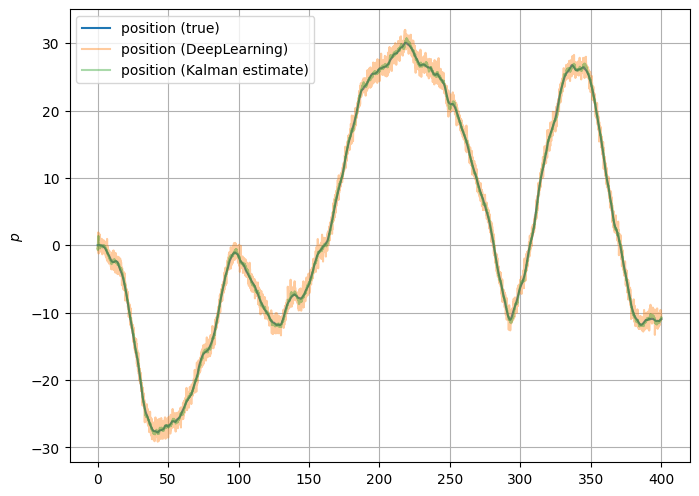

In [7]:
n=2
##########            칼만 생성            ##########
sigma_w = B_test@B_test.T
sigma_v = 1
hat_x = np.zeros((2,N_test))
hat_x[:,0] = np.array([0,0])
sigma = np.eye(2)*10
for t in range(N_test-1):
    K = A_test@sigma@C_test.T@np.linalg.inv(C_test@sigma@C_test.T+sigma_v)
    hat_x[:,t+1] = A_test@hat_x[:,t] + K@(y_test[0,t] - C_test@hat_x[:,t])
    sigma = A_test@sigma@A_test.T - K@C_test@sigma@A_test.T+sigma_w


##########            딥러닝 생성            ##########
test = []
for i in range(len(y_test[0])-n):
    test.append(y_test[0,i:i+n].reshape(n,-1))
x_test_ready_2 = np.array(test).reshape(-1,n)
y_test_ready_2 = x_test[0,n:-1]
position_hat = model_2.predict(x_test_ready_2)


##########            n개 평균 생성            ##########
temp = []
for i in range(len(y_test[0])-n):
    avg = 0
    for j in range(i,i+n):
        avg+=y_test[0,j]
    temp.append(avg/n)
y_n = np.array(temp)
##########            시각화            ##########

plt.figure(figsize=(8,6), dpi=100)
plt.plot(ts_test[n:-1],x_test[0,n:-1], label='position (true)')
plt.plot(ts_test[n:-1],position_hat[:], alpha=0.4, label='position (DeepLearning)')
plt.plot(ts_test[n:-1],hat_x[0,n:],alpha = 0.4, label='position (Kalman estimate)')
#plt.plot(ts_test[n:-1],y_n[:],alpha = 0.3, label='position (n_average)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

Kalman_RMSE = 0
DeepLearning_RMSE = 0
for k in range(len(y_test[0])-n):
    Kalman_RMSE += (x_test[0,n:-1][k]-hat_x[0,n:][k])**2
    DeepLearning_RMSE += (x_test[0,n:-1][k]-position_hat[k])**2
Kalman_RMSE = (Kalman_RMSE/(len(y_test[0])-n))**0.5
DeepLearning_RMSE = (DeepLearning_RMSE/(len(y_test[0])-n))**0.5
Kalman_RMSE_list_G.append(Kalman_RMSE)
DeepLearning_RMSE_list_G.append(DeepLearning_RMSE[0])
print('               n  : ',n)
print('      Kalman_RMSE : ',Kalman_RMSE)
print('DeepLearning_RMSE : ',DeepLearning_RMSE[0])


##### n=4

In [8]:
n=4
temp = []
for i in range(len(y[0])-n):
    temp.append(y[0,i:i+n].reshape(n,-1))
x_train = np.array(temp).reshape(-1,n)
y_train = x[0,n:-1]
model_4 = Sequential()
model_4.add(Dense(1,input_dim = n))
model_4.compile(loss = 'mse',optimizer = 'adam',metrics = ['accuracy'])
history = model_4.fit(x_train,y_train,epochs = epochs,verbose = 0,batch_size=batch_size)
position_hat = model_4.predict(x_train)

#plt.figure(figsize=(8,6), dpi=100)
#plt.plot(ts[n:-1],x[0,n:-1], label='position (true)')
#plt.plot(ts[n:-1],position_hat[:], alpha=0.5, label='position (measured)')
#plt.ylabel(r'$p$')
#plt.legend()
#plt.grid()

               n  :  4
      Kalman_RMSE :  0.26792070415365804
DeepLearning_RMSE :  0.52384776


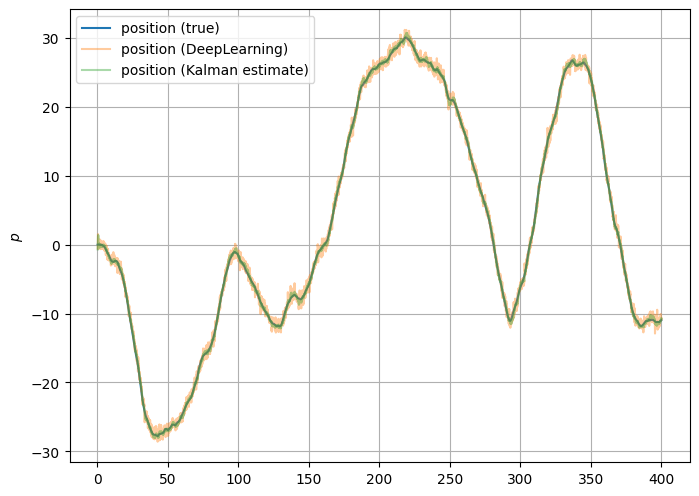

In [9]:
n=4
##########            칼만 생성            ##########
sigma_w = B_test@B_test.T
sigma_v = 1
hat_x = np.zeros((2,N_test))
hat_x[:,0] = np.array([0,0])
sigma = np.eye(2)*10
for t in range(N_test-1):
    K = A_test@sigma@C_test.T@np.linalg.inv(C_test@sigma@C_test.T+sigma_v)
    hat_x[:,t+1] = A_test@hat_x[:,t] + K@(y_test[0,t] - C_test@hat_x[:,t])
    sigma = A_test@sigma@A_test.T - K@C_test@sigma@A_test.T+sigma_w


##########            딥러닝 생성            ##########
test = []
for i in range(len(y_test[0])-n):
    test.append(y_test[0,i:i+n].reshape(n,-1))
x_test_ready_4 = np.array(test).reshape(-1,n)
y_test_ready_4 = x_test[0,n:-1]
position_hat = model_4.predict(x_test_ready_4)


##########            n개 평균 생성            ##########
temp = []
for i in range(len(y_test[0])-n):
    avg = 0
    for j in range(i,i+n):
        avg+=y_test[0,j]
    temp.append(avg/n)
y_n = np.array(temp)
##########            시각화            ##########
plt.figure(figsize=(8,6), dpi=100)
plt.plot(ts_test[n:-1],x_test[0,n:-1], label='position (true)')
plt.plot(ts_test[n:-1],position_hat[:], alpha=0.4, label='position (DeepLearning)')
plt.plot(ts_test[n:-1],hat_x[0,n:],alpha = 0.4, label='position (Kalman estimate)')
#plt.plot(ts_test[n:-1],y_n[:],alpha = 0.2, label='position (n_average)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

Kalman_RMSE = 0
DeepLearning_RMSE = 0
for k in range(len(y_test[0])-n):
    Kalman_RMSE += (x_test[0,n:-1][k]-hat_x[0,n:][k])**2
    DeepLearning_RMSE += (x_test[0,n:-1][k]-position_hat[k])**2
Kalman_RMSE = (Kalman_RMSE/(len(y_test[0])-n))**0.5
DeepLearning_RMSE = (DeepLearning_RMSE/(len(y_test[0])-n))**0.5
Kalman_RMSE_list_G.append(Kalman_RMSE)
DeepLearning_RMSE_list_G.append(DeepLearning_RMSE[0])
print('               n  : ',n)
print('      Kalman_RMSE : ',Kalman_RMSE)
print('DeepLearning_RMSE : ',DeepLearning_RMSE[0])


##### n=10

In [10]:
n=10
temp = []
for i in range(len(y[0])-n):
    temp.append(y[0,i:i+n].reshape(n,-1))
x_train = np.array(temp).reshape(-1,n)
y_train = x[0,n:-1]
model_10 = Sequential()
model_10.add(Dense(1,input_dim = n))
model_10.compile(loss = 'mse',optimizer = 'adam',metrics = ['accuracy'])
history = model_10.fit(x_train,y_train,epochs = epochs,verbose = 0,batch_size=batch_size)
position_hat = model_10.predict(x_train)

#plt.figure(figsize=(8,6), dpi=100)
#plt.plot(ts[n:-1],x[0,n:-1], label='position (true)')
#plt.plot(ts[n:-1],position_hat[:], alpha=0.5, label='position (measured)')
#plt.ylabel(r'$p$')
#plt.legend()
#plt.grid()

               n  :  10
      Kalman_RMSE :  0.266978347422292
DeepLearning_RMSE :  0.37680936


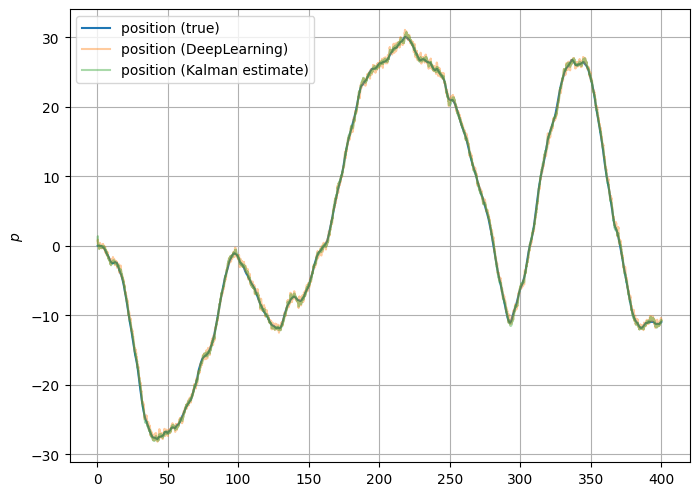

In [11]:
n=10
##########            칼만 생성            ##########
sigma_w = B_test@B_test.T
sigma_v = 1
hat_x = np.zeros((2,N_test))
hat_x[:,0] = np.array([0,0])
sigma = np.eye(2)*10
for t in range(N_test-1):
    K = A_test@sigma@C_test.T@np.linalg.inv(C_test@sigma@C_test.T+sigma_v)
    hat_x[:,t+1] = A_test@hat_x[:,t] + K@(y_test[0,t] - C_test@hat_x[:,t])
    sigma = A_test@sigma@A_test.T - K@C_test@sigma@A_test.T+sigma_w


##########            딥러닝 생성            ##########
test = []
for i in range(len(y_test[0])-n):
    test.append(y_test[0,i:i+n].reshape(n,-1))
x_test_ready_10 = np.array(test).reshape(-1,n)
y_test_ready_10 = x_test[0,n:-1]
position_hat = model_10.predict(x_test_ready_10)


##########            n개 평균 생성            ##########
temp = []
for i in range(len(y_test[0])-n):
    avg = 0
    for j in range(i,i+n):
        avg+=y_test[0,j]
    temp.append(avg/n)
y_n = np.array(temp)
##########            시각화            ##########

plt.figure(figsize=(8,6), dpi=100)
plt.plot(ts_test[n:-1],x_test[0,n:-1], label='position (true)')
plt.plot(ts_test[n:-1],position_hat[:], alpha=0.4, label='position (DeepLearning)')
plt.plot(ts_test[n:-1],hat_x[0,n:],alpha = 0.4, label='position (Kalman estimate)')
#plt.plot(ts_test[n:-1],y_n[:],alpha = 0.2, label='position (n_average)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

Kalman_RMSE = 0
DeepLearning_RMSE = 0
for k in range(len(y_test[0])-n):
    Kalman_RMSE += (x_test[0,n:-1][k]-hat_x[0,n:][k])**2
    DeepLearning_RMSE += (x_test[0,n:-1][k]-position_hat[k])**2
Kalman_RMSE = (Kalman_RMSE/(len(y_test[0])-n))**0.5
DeepLearning_RMSE = (DeepLearning_RMSE/(len(y_test[0])-n))**0.5
Kalman_RMSE_list_G.append(Kalman_RMSE)
DeepLearning_RMSE_list_G.append(DeepLearning_RMSE[0])
print('               n  : ',n)
print('      Kalman_RMSE : ',Kalman_RMSE)
print('DeepLearning_RMSE : ',DeepLearning_RMSE[0])

##### n=20

In [12]:
n=20
temp = []
for i in range(len(y[0])-n):
    temp.append(y[0,i:i+n].reshape(n,-1))
x_train = np.array(temp).reshape(-1,n)
y_train = x[0,n:-1]
model_20 = Sequential()
model_20.add(Dense(1,input_dim = n))
model_20.compile(loss = 'mse',optimizer = 'adam',metrics = ['accuracy'])
history = model_20.fit(x_train,y_train,epochs = epochs,verbose = 0,batch_size=batch_size)
position_hat = model_20.predict(x_train)
#plt.figure(figsize=(8,6), dpi=100)
#plt.plot(ts[n:-1],x[0,n:-1], label='position (true)')
#plt.plot(ts[n:-1],position_hat[:], alpha=0.5, label='position (measured)')
#plt.ylabel(r'$p$')
#plt.legend()
#plt.grid()

               n  :  20
      Kalman_RMSE :  0.2658955745094474
DeepLearning_RMSE :  0.37252274


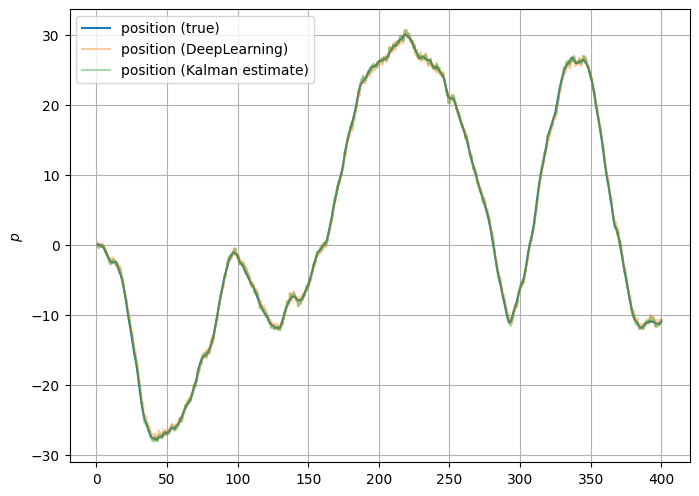

In [13]:
n=20
##########            칼만 생성            ##########
sigma_w = B_test@B_test.T
sigma_v = 1
hat_x = np.zeros((2,N_test))
hat_x[:,0] = np.array([0,0])
sigma = np.eye(2)*10
for t in range(N_test-1):
    K = A_test@sigma@C_test.T@np.linalg.inv(C_test@sigma@C_test.T+sigma_v)
    hat_x[:,t+1] = A_test@hat_x[:,t] + K@(y_test[0,t] - C_test@hat_x[:,t])
    sigma = A_test@sigma@A_test.T - K@C_test@sigma@A_test.T+sigma_w


##########            딥러닝 생성            ##########
test = []
for i in range(len(y_test[0])-n):
    test.append(y_test[0,i:i+n].reshape(n,-1))
x_test_ready_20 = np.array(test).reshape(-1,n)
y_test_ready_20 = x_test[0,n:-1]
position_hat = model_20.predict(x_test_ready_20)


##########            n개 평균 생성            ##########
temp = []
for i in range(len(y_test[0])-n):
    avg = 0
    for j in range(i,i+n):
        avg+=y_test[0,j]
    temp.append(avg/n)
y_n = np.array(temp)
##########            시각화            ##########

plt.figure(figsize=(8,6), dpi=100)
plt.plot(ts_test[n:-1],x_test[0,n:-1], label='position (true)')
plt.plot(ts_test[n:-1],position_hat[:], alpha=0.4, label='position (DeepLearning)')
plt.plot(ts_test[n:-1],hat_x[0,n:],alpha = 0.4, label='position (Kalman estimate)')
#plt.plot(ts_test[n:-1],y_n[:],alpha = 0.2, label='position (n_average)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

Kalman_RMSE = 0
DeepLearning_RMSE = 0
for k in range(len(y_test[0])-n):
    Kalman_RMSE += (x_test[0,n:-1][k]-hat_x[0,n:][k])**2
    DeepLearning_RMSE += (x_test[0,n:-1][k]-position_hat[k])**2
Kalman_RMSE = (Kalman_RMSE/(len(y_test[0])-n))**0.5
DeepLearning_RMSE = (DeepLearning_RMSE/(len(y_test[0])-n))**0.5
Kalman_RMSE_list_G.append(Kalman_RMSE)
DeepLearning_RMSE_list_G.append(DeepLearning_RMSE[0])
print('               n  : ',n)
print('      Kalman_RMSE : ',Kalman_RMSE)
print('DeepLearning_RMSE : ',DeepLearning_RMSE[0])

##### n=50

In [14]:
n=50
temp = []
for i in range(len(y[0])-n):
    temp.append(y[0,i:i+n].reshape(n,-1))
x_train = np.array(temp).reshape(-1,n)
y_train = x[0,n:-1]
model_50 = Sequential()
model_50.add(Dense(1,input_dim = n))
model_50.compile(loss = 'mse',optimizer = 'adam',metrics = ['accuracy'])
history = model_50.fit(x_train,y_train,epochs = epochs,verbose = 0,batch_size=batch_size)
position_hat = model_50.predict(x_train)

#plt.figure(figsize=(8,6), dpi=100)
#plt.plot(ts[n:-1],x[0,n:-1], label='position (true)')
#plt.plot(ts[n:-1],position_hat[:], alpha=0.5, label='position (measured)')
#plt.ylabel(r'$p$')
#plt.legend()
#plt.grid()

               n  :  50
      Kalman_RMSE :  0.26613705548322086
DeepLearning_RMSE :  0.2940287


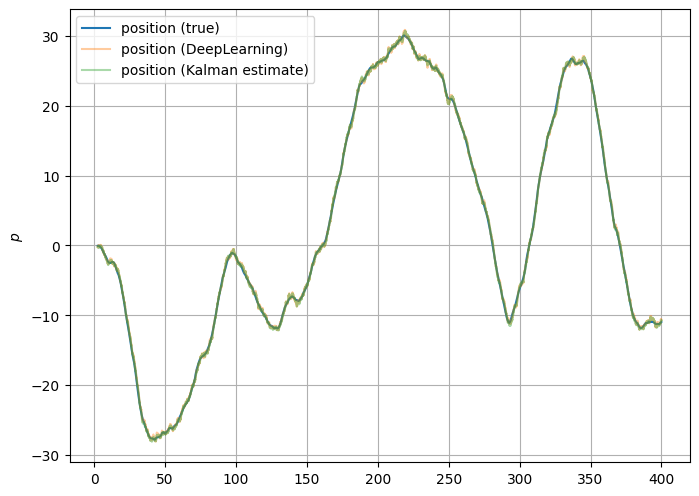

In [15]:
n=50
##########            칼만 생성            ##########
sigma_w = B_test@B_test.T
sigma_v = 1
hat_x = np.zeros((2,N_test))
hat_x[:,0] = np.array([0,0])
sigma = np.eye(2)*10
for t in range(N_test-1):
    K = A_test@sigma@C_test.T@np.linalg.inv(C_test@sigma@C_test.T+sigma_v)
    hat_x[:,t+1] = A_test@hat_x[:,t] + K@(y_test[0,t] - C_test@hat_x[:,t])
    sigma = A_test@sigma@A_test.T - K@C_test@sigma@A_test.T+sigma_w


##########            딥러닝 생성            ##########
test = []
for i in range(len(y_test[0])-n):
    test.append(y_test[0,i:i+n].reshape(n,-1))
x_test_ready_50 = np.array(test).reshape(-1,n)
y_test_ready_50 = x_test[0,n:-1]
position_hat = model_50.predict(x_test_ready_50)


##########            n개 평균 생성            ##########
temp = []
for i in range(len(y_test[0])-n):
    avg = 0
    for j in range(i,i+n):
        avg+=y_test[0,j]
    temp.append(avg/n)
y_n = np.array(temp)
##########            시각화            ##########

plt.figure(figsize=(8,6), dpi=100)
plt.plot(ts_test[n:-1],x_test[0,n:-1], label='position (true)')
plt.plot(ts_test[n:-1],position_hat[:], alpha=0.4, label='position (DeepLearning)')
plt.plot(ts_test[n:-1],hat_x[0,n:],alpha = 0.4, label='position (Kalman estimate)')
#plt.plot(ts_test[n:-1],y_n[:],alpha = 0.2, label='position (n_average)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

Kalman_RMSE = 0
DeepLearning_RMSE = 0
for k in range(len(y_test[0])-n):
    Kalman_RMSE += (x_test[0,n:-1][k]-hat_x[0,n:][k])**2
    DeepLearning_RMSE += (x_test[0,n:-1][k]-position_hat[k])**2
Kalman_RMSE = (Kalman_RMSE/(len(y_test[0])-n))**0.5
DeepLearning_RMSE = (DeepLearning_RMSE/(len(y_test[0])-n))**0.5
Kalman_RMSE_list_G.append(Kalman_RMSE)
DeepLearning_RMSE_list_G.append(DeepLearning_RMSE[0])
print('               n  : ',n)
print('      Kalman_RMSE : ',Kalman_RMSE)
print('DeepLearning_RMSE : ',DeepLearning_RMSE[0])


##### n=200

In [16]:
n=200
temp = []
for i in range(len(y[0])-n):
    temp.append(y[0,i:i+n].reshape(n,-1))
x_train = np.array(temp).reshape(-1,n)
y_train = x[0,n:-1]
model_200 = Sequential()
model_200.add(Dense(1,input_dim = n))
model_200.compile(loss = 'mse',optimizer = 'adam',metrics = ['accuracy'])
history = model_200.fit(x_train,y_train,epochs = epochs,verbose = 0,batch_size=batch_size)
position_hat = model_200.predict(x_train)

#plt.figure(figsize=(8,6), dpi=100)
#plt.plot(ts[n:-1],x[0,n:-1], label='position (true)')
#plt.plot(ts[n:-1],position_hat[:], alpha=0.5, label='position (measured)')
#plt.ylabel(r'$p$')
#plt.legend()
#plt.grid()

               n  :  200
      Kalman_RMSE :  0.2672073678663738
DeepLearning_RMSE :  0.283516


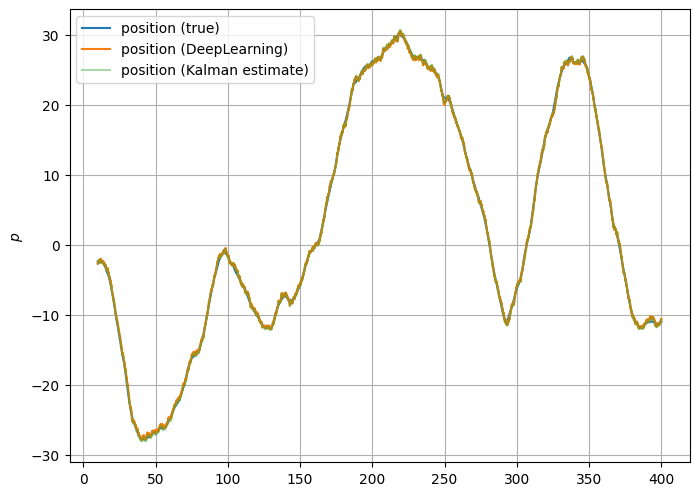

In [17]:
n=200
##########            칼만 생성            ##########
sigma_w = B_test@B_test.T
sigma_v = 1
hat_x = np.zeros((2,N_test))
hat_x[:,0] = np.array([0,0])
sigma = np.eye(2)*10
for t in range(N_test-1):
    K = A_test@sigma@C_test.T@np.linalg.inv(C_test@sigma@C_test.T+sigma_v)
    hat_x[:,t+1] = A_test@hat_x[:,t] + K@(y_test[0,t] - C_test@hat_x[:,t])
    sigma = A_test@sigma@A_test.T - K@C_test@sigma@A_test.T+sigma_w


##########            딥러닝 생성            ##########
test = []
for i in range(len(y_test[0])-n):
    test.append(y_test[0,i:i+n].reshape(n,-1))
x_test_ready_200 = np.array(test).reshape(-1,n)
y_test_ready_200 = x_test[0,n:-1]
position_hat = model_200.predict(x_test_ready_200)


##########            n개 평균 생성            ##########
temp = []
for i in range(len(y_test[0])-n):
    avg = 0
    for j in range(i,i+n):
        avg+=y_test[0,j]
    temp.append(avg/n)
y_n = np.array(temp)
##########            시각화            ##########

plt.figure(figsize=(8,6), dpi=100)
plt.plot(ts_test[n:-1],x_test[0,n:-1], label='position (true)')
plt.plot(ts_test[n:-1],position_hat[:], alpha=1, label='position (DeepLearning)')
plt.plot(ts_test[n:-1],hat_x[0,n:],alpha = 0.4, label='position (Kalman estimate)')
#plt.plot(ts_test[n:-1],y_n[:],alpha = 0.2, label='position (n_average)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

Kalman_RMSE = 0
DeepLearning_RMSE = 0
for k in range(len(y_test[0])-n):
    Kalman_RMSE += (x_test[0,n:-1][k]-hat_x[0,n:][k])**2
    DeepLearning_RMSE += (x_test[0,n:-1][k]-position_hat[k])**2
Kalman_RMSE = (Kalman_RMSE/(len(y_test[0])-n))**0.5
DeepLearning_RMSE = (DeepLearning_RMSE/(len(y_test[0])-n))**0.5
Kalman_RMSE_list_G.append(Kalman_RMSE)
DeepLearning_RMSE_list_G.append(DeepLearning_RMSE[0])
print('               n  : ',n)
print('      Kalman_RMSE : ',Kalman_RMSE)
print('DeepLearning_RMSE : ',DeepLearning_RMSE[0])


# 층 추가

##### 이번에는 여러 층을 추가한다 총 4개의 층을 만든다. 각각의 노드는 50,25,5,1이고 활성화 함수는 Relu로 한다. 마찬가지고 n=2,4,10,20,50,200

##### n=2

In [59]:
n=2
temp = []
for i in range(len(y[0])-n):
    temp.append(y[0,i:i+n].reshape(n,-1))
x_train = np.array(temp).reshape(-1,n)
y_train = x[0,n:-1]
model_2_multilayer = Sequential()
model_2_multilayer.add(Dense(50,input_dim = n,activation='relu'))
model_2_multilayer.add(Dense(25,activation='relu'))
model_2_multilayer.add(Dense(5,activation='relu'))
model_2_multilayer.add(Dense(1))
model_2_multilayer.compile(loss = 'mse',optimizer = 'adam',metrics = ['accuracy'])
history = model_2_multilayer.fit(x_train,y_train,epochs = epochs,verbose = 0,batch_size=batch_size)
position_hat = model_2_multilayer.predict(x_train)

#plt.figure(figsize=(8,6), dpi=100)
#plt.plot(ts[n:-1],x[0,n:-1], label='position (true)')
#plt.plot(ts[n:-1],position_hat[:], alpha=0.5, label='position (measured)')
#plt.ylabel(r'$p$')
#plt.legend()
#plt.grid()

               n  :  2
      Kalman_RMSE :  0.267955093502243
DeepLearning_RMSE :  9.779609


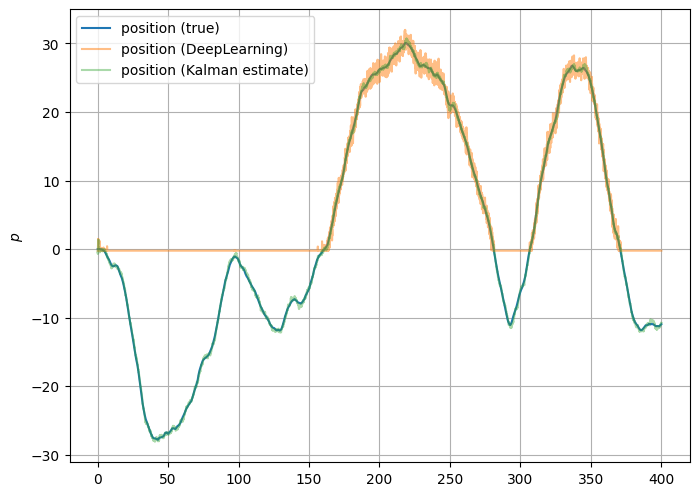

In [19]:
n=2
##########            칼만 생성            ##########
sigma_w = B_test@B_test.T
sigma_v = 1
hat_x = np.zeros((2,N_test))
hat_x[:,0] = np.array([0,0])
sigma = np.eye(2)*10
for t in range(N_test-1):
    K = A_test@sigma@C_test.T@np.linalg.inv(C_test@sigma@C_test.T+sigma_v)
    hat_x[:,t+1] = A_test@hat_x[:,t] + K@(y_test[0,t] - C_test@hat_x[:,t])
    sigma = A_test@sigma@A_test.T - K@C_test@sigma@A_test.T+sigma_w


##########            딥러닝 생성            ##########
test = []
for i in range(len(y_test[0])-n):
    test.append(y_test[0,i:i+n].reshape(n,-1))
x_test_ready_2_multilayer = np.array(test).reshape(-1,n)
y_test_ready_2_multilayer = x_test[0,n:-1]
position_hat = model_2_multilayer.predict(x_test_ready_2_multilayer)


##########            n개 평균 생성            ##########
temp = []
for i in range(len(y_test[0])-n):
    avg = 0
    for j in range(i,i+n):
        avg+=y_test[0,j]
    temp.append(avg/n)
y_n = np.array(temp)
##########            시각화            ##########

plt.figure(figsize=(8,6), dpi=100)
plt.plot(ts_test[n:-1],x_test[0,n:-1], label='position (true)')
plt.plot(ts_test[n:-1],position_hat[:], alpha=0.5, label='position (DeepLearning)')
plt.plot(ts_test[n:-1],hat_x[0,n:],alpha = 0.4, label='position (Kalman estimate)')
#plt.plot(ts_test[n:-1],y_n[:],alpha = 0.2, label='position (n_average)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

Kalman_RMSE = 0
DeepLearning_RMSE = 0
for k in range(len(y_test[0])-n):
    Kalman_RMSE += (x_test[0,n:-1][k]-hat_x[0,n:][k])**2
    DeepLearning_RMSE += (x_test[0,n:-1][k]-position_hat[k])**2
Kalman_RMSE = (Kalman_RMSE/(len(y_test[0])-n))**0.5
DeepLearning_RMSE = (DeepLearning_RMSE/(len(y_test[0])-n))**0.5
Kalman_RMSE_list_G.append(Kalman_RMSE)
DeepLearning_RMSE_list_G.append(DeepLearning_RMSE[0])
print('               n  : ',n)
print('      Kalman_RMSE : ',Kalman_RMSE)
print('DeepLearning_RMSE : ',DeepLearning_RMSE[0])

##### n=4

In [60]:
n=4
temp = []
for i in range(len(y[0])-n):
    temp.append(y[0,i:i+n].reshape(n,-1))
x_train = np.array(temp).reshape(-1,n)
y_train = x[0,n:-1]
model_4_multilayer = Sequential()
model_4_multilayer.add(Dense(50,input_dim = n,activation='relu'))
model_4_multilayer.add(Dense(25,activation='relu'))
model_4_multilayer.add(Dense(5,activation='relu'))
model_4_multilayer.add(Dense(1))
model_4_multilayer.compile(loss = 'mse',optimizer = 'adam',metrics = ['accuracy'])
history = model_4_multilayer.fit(x_train,y_train,epochs = epochs,verbose = 0,batch_size=batch_size)
position_hat = model_4_multilayer.predict(x_train)

#plt.figure(figsize=(8,6), dpi=100)
#plt.plot(ts[n:-1],x[0,n:-1], label='position (true)')
#plt.plot(ts[n:-1],position_hat[:], alpha=0.5, label='position (measured)')
#plt.ylabel(r'$p$')
#plt.legend()
#plt.grid()

               n  :  4
      Kalman_RMSE :  0.26792070415365804
DeepLearning_RMSE :  10.599646


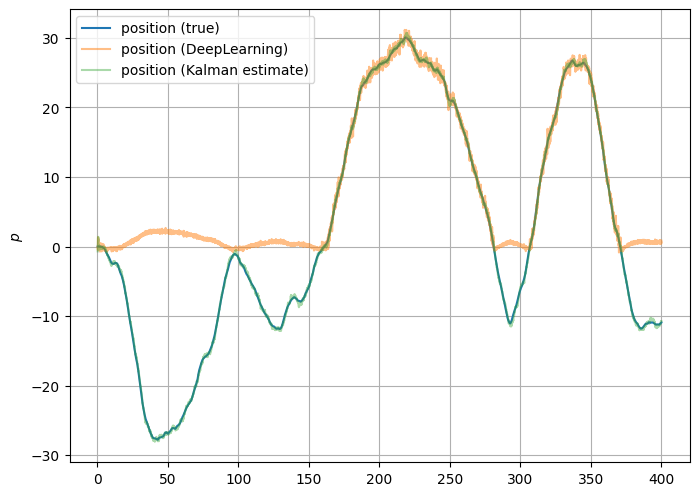

In [21]:
n=4
##########            칼만 생성            ##########
sigma_w = B_test@B_test.T
sigma_v = 1
hat_x = np.zeros((2,N_test))
hat_x[:,0] = np.array([0,0])
sigma = np.eye(2)*10
for t in range(N_test-1):
    K = A_test@sigma@C_test.T@np.linalg.inv(C_test@sigma@C_test.T+sigma_v)
    hat_x[:,t+1] = A_test@hat_x[:,t] + K@(y_test[0,t] - C_test@hat_x[:,t])
    sigma = A_test@sigma@A_test.T - K@C_test@sigma@A_test.T+sigma_w


##########            딥러닝 생성            ##########
test = []
for i in range(len(y_test[0])-n):
    test.append(y_test[0,i:i+n].reshape(n,-1))
x_test_ready_4_multilayer = np.array(test).reshape(-1,n)
y_test_ready_4_multilayer = x_test[0,n:-1]
position_hat = model_4_multilayer.predict(x_test_ready_4_multilayer)


##########            n개 평균 생성            ##########
temp = []
for i in range(len(y_test[0])-n):
    avg = 0
    for j in range(i,i+n):
        avg+=y_test[0,j]
    temp.append(avg/n)
y_n = np.array(temp)
##########            시각화            ##########

plt.figure(figsize=(8,6), dpi=100)
plt.plot(ts_test[n:-1],x_test[0,n:-1], label='position (true)')
plt.plot(ts_test[n:-1],position_hat[:], alpha=0.5, label='position (DeepLearning)')
plt.plot(ts_test[n:-1],hat_x[0,n:],alpha = 0.4, label='position (Kalman estimate)')
#plt.plot(ts_test[n:-1],y_n[:],alpha = 0.2, label='position (n_average)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

Kalman_RMSE = 0
DeepLearning_RMSE = 0
for k in range(len(y_test[0])-n):
    Kalman_RMSE += (x_test[0,n:-1][k]-hat_x[0,n:][k])**2
    DeepLearning_RMSE += (x_test[0,n:-1][k]-position_hat[k])**2
Kalman_RMSE = (Kalman_RMSE/(len(y_test[0])-n))**0.5
DeepLearning_RMSE = (DeepLearning_RMSE/(len(y_test[0])-n))**0.5
Kalman_RMSE_list_G.append(Kalman_RMSE)
DeepLearning_RMSE_list_G.append(DeepLearning_RMSE[0])
print('               n  : ',n)
print('      Kalman_RMSE : ',Kalman_RMSE)
print('DeepLearning_RMSE : ',DeepLearning_RMSE[0])

##### n=10

In [61]:
n=10
temp = []
for i in range(len(y[0])-n):
    temp.append(y[0,i:i+n].reshape(n,-1))
x_train = np.array(temp).reshape(-1,n)
y_train = x[0,n:-1]
model_10_multilayer = Sequential()
model_10_multilayer.add(Dense(50,input_dim = n,activation='relu'))
model_10_multilayer.add(Dense(25,activation='relu'))
model_10_multilayer.add(Dense(5,activation='relu'))
model_10_multilayer.add(Dense(1))
model_10_multilayer.compile(loss = 'mse',optimizer = 'adam',metrics = ['accuracy'])
history = model_10_multilayer.fit(x_train,y_train,epochs = epochs,verbose = 0,batch_size=batch_size)
position_hat = model_10_multilayer.predict(x_train)

#plt.figure(figsize=(8,6), dpi=100)
#plt.plot(ts[n:-1],x[0,n:-1], label='position (true)')
#plt.plot(ts[n:-1],position_hat[:], alpha=0.5, label='position (measured)')
#plt.ylabel(r'$p$')
#plt.legend()
#plt.grid()

               n  :  10
      Kalman_RMSE :  0.266978347422292
DeepLearning_RMSE :  8.363823


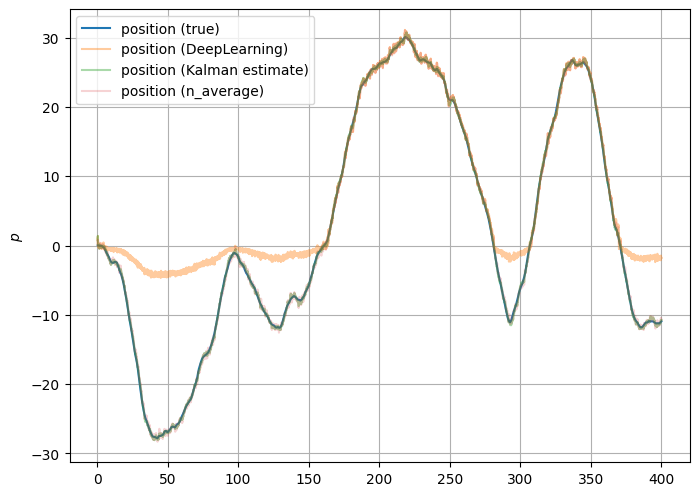

In [23]:
n=10
##########            칼만 생성            ##########
sigma_w = B_test@B_test.T
sigma_v = 1
hat_x = np.zeros((2,N_test))
hat_x[:,0] = np.array([0,0])
sigma = np.eye(2)*10
for t in range(N_test-1):
    K = A_test@sigma@C_test.T@np.linalg.inv(C_test@sigma@C_test.T+sigma_v)
    hat_x[:,t+1] = A_test@hat_x[:,t] + K@(y_test[0,t] - C_test@hat_x[:,t])
    sigma = A_test@sigma@A_test.T - K@C_test@sigma@A_test.T+sigma_w


##########            딥러닝 생성            ##########
test = []
for i in range(len(y_test[0])-n):
    test.append(y_test[0,i:i+n].reshape(n,-1))
x_test_ready_10_multilayer = np.array(test).reshape(-1,n)
y_test_ready_10_multilayer = x_test[0,n:-1]
position_hat = model_10_multilayer.predict(x_test_ready_10_multilayer)


##########            n개 평균 생성            ##########
temp = []
for i in range(len(y_test[0])-n):
    avg = 0
    for j in range(i,i+n):
        avg+=y_test[0,j]
    temp.append(avg/n)
y_n = np.array(temp)
##########            시각화            ##########

plt.figure(figsize=(8,6), dpi=100)
plt.plot(ts_test[n:-1],x_test[0,n:-1], label='position (true)')
plt.plot(ts_test[n:-1],position_hat[:], alpha=0.4, label='position (DeepLearning)')
plt.plot(ts_test[n:-1],hat_x[0,n:],alpha = 0.4, label='position (Kalman estimate)')
plt.plot(ts_test[n:-1],y_n[:],alpha = 0.2, label='position (n_average)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

Kalman_RMSE = 0
DeepLearning_RMSE = 0
for k in range(len(y_test[0])-n):
    Kalman_RMSE += (x_test[0,n:-1][k]-hat_x[0,n:][k])**2
    DeepLearning_RMSE += (x_test[0,n:-1][k]-position_hat[k])**2
Kalman_RMSE = (Kalman_RMSE/(len(y_test[0])-n))**0.5
DeepLearning_RMSE = (DeepLearning_RMSE/(len(y_test[0])-n))**0.5
Kalman_RMSE_list_G.append(Kalman_RMSE)
DeepLearning_RMSE_list_G.append(DeepLearning_RMSE[0])
print('               n  : ',n)
print('      Kalman_RMSE : ',Kalman_RMSE)
print('DeepLearning_RMSE : ',DeepLearning_RMSE[0])

##### n=20

In [62]:
n=20
temp = []
for i in range(len(y[0])-n):
    temp.append(y[0,i:i+n].reshape(n,-1))
x_train = np.array(temp).reshape(-1,n)
y_train = x[0,n:-1]
model_20_multilayer = Sequential()
model_20_multilayer.add(Dense(50,input_dim = n,activation='relu'))
model_20_multilayer.add(Dense(25,activation='relu'))
model_20_multilayer.add(Dense(5,activation='relu'))
model_20_multilayer.add(Dense(1))
model_20_multilayer.compile(loss = 'mse',optimizer = 'adam',metrics = ['accuracy'])
history = model_20_multilayer.fit(x_train,y_train,epochs = epochs,verbose = 0,batch_size=batch_size)
position_hat = model_20_multilayer.predict(x_train)

#plt.figure(figsize=(8,6), dpi=100)
#plt.plot(ts[n:-1],x[0,n:-1], label='position (true)')
#plt.plot(ts[n:-1],position_hat[:], alpha=0.5, label='position (measured)')
#plt.ylabel(r'$p$')
#plt.legend()
#plt.grid()

               n  :  20
      Kalman_RMSE :  0.2658955745094474
DeepLearning_RMSE :  5.524909


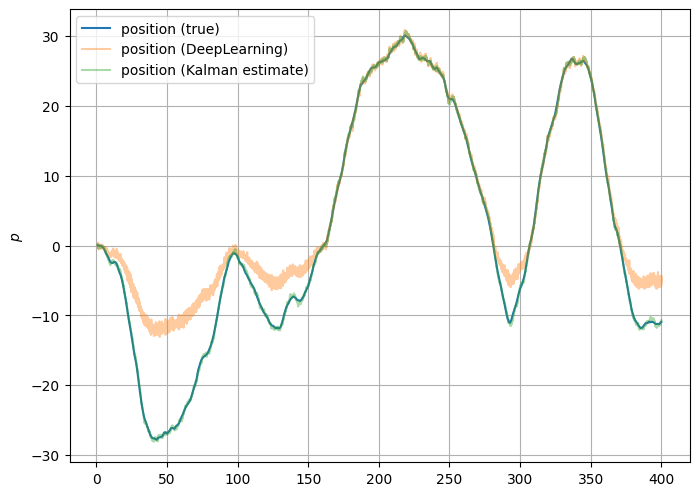

In [25]:
n=20
##########            칼만 생성            ##########
sigma_w = B_test@B_test.T
sigma_v = 1
hat_x = np.zeros((2,N_test))
hat_x[:,0] = np.array([0,0])
sigma = np.eye(2)*10
for t in range(N_test-1):
    K = A_test@sigma@C_test.T@np.linalg.inv(C_test@sigma@C_test.T+sigma_v)
    hat_x[:,t+1] = A_test@hat_x[:,t] + K@(y_test[0,t] - C_test@hat_x[:,t])
    sigma = A_test@sigma@A_test.T - K@C_test@sigma@A_test.T+sigma_w


##########            딥러닝 생성            ##########
test = []
for i in range(len(y_test[0])-n):
    test.append(y_test[0,i:i+n].reshape(n,-1))
x_test_ready_20_multilayer = np.array(test).reshape(-1,n)
y_test_ready_20_multilayer = x_test[0,n:-1]
position_hat = model_20_multilayer.predict(x_test_ready_20_multilayer)


##########            n개 평균 생성            ##########
temp = []
for i in range(len(y_test[0])-n):
    avg = 0
    for j in range(i,i+n):
        avg+=y_test[0,j]
    temp.append(avg/n)
y_n = np.array(temp)
##########            시각화            ##########

plt.figure(figsize=(8,6), dpi=100)
plt.plot(ts_test[n:-1],x_test[0,n:-1], label='position (true)')
plt.plot(ts_test[n:-1],position_hat[:], alpha=0.4, label='position (DeepLearning)')
plt.plot(ts_test[n:-1],hat_x[0,n:],alpha = 0.4, label='position (Kalman estimate)')
#plt.plot(ts_test[n:-1],y_n[:],alpha = 0.2, label='position (n_average)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

Kalman_RMSE = 0
DeepLearning_RMSE = 0
for k in range(len(y_test[0])-n):
    Kalman_RMSE += (x_test[0,n:-1][k]-hat_x[0,n:][k])**2
    DeepLearning_RMSE += (x_test[0,n:-1][k]-position_hat[k])**2
Kalman_RMSE = (Kalman_RMSE/(len(y_test[0])-n))**0.5
DeepLearning_RMSE = (DeepLearning_RMSE/(len(y_test[0])-n))**0.5
Kalman_RMSE_list_G.append(Kalman_RMSE)
DeepLearning_RMSE_list_G.append(DeepLearning_RMSE[0])
print('               n  : ',n)
print('      Kalman_RMSE : ',Kalman_RMSE)
print('DeepLearning_RMSE : ',DeepLearning_RMSE[0])

##### n=50

In [26]:
n=50
temp = []
for i in range(len(y[0])-n):
    temp.append(y[0,i:i+n].reshape(n,-1))
x_train = np.array(temp).reshape(-1,n)
y_train = x[0,n:-1]
model_50_multilayer = Sequential()
model_50_multilayer.add(Dense(50,input_dim = n,activation='relu'))
model_50_multilayer.add(Dense(25,activation='relu'))
model_50_multilayer.add(Dense(5,activation='relu'))
model_50_multilayer.add(Dense(1))
model_50_multilayer.compile(loss = 'mse',optimizer = 'adam',metrics = ['accuracy'])
history = model_50_multilayer.fit(x_train,y_train,epochs = epochs,verbose = 0,batch_size=batch_size)
position_hat = model_50_multilayer.predict(x_train)

#plt.figure(figsize=(8,6), dpi=100)
#plt.plot(ts[n:-1],x[0,n:-1], label='position (true)')
#plt.plot(ts[n:-1],position_hat[:], alpha=0.5, label='position (measured)')
#plt.ylabel(r'$p$')
#plt.legend()
#plt.grid()


               n  :  50
      Kalman_RMSE :  0.26613705548322086
DeepLearning_RMSE :  7.0002394


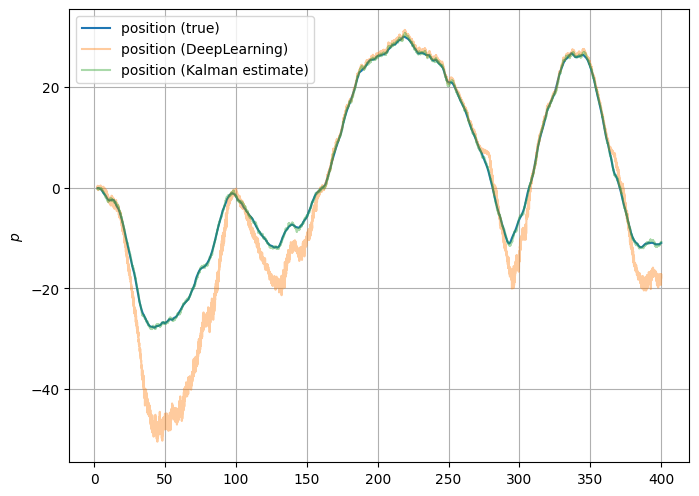

In [27]:
n=50
##########            칼만 생성            ##########
sigma_w = B_test@B_test.T
sigma_v = 1
hat_x = np.zeros((2,N_test))
hat_x[:,0] = np.array([0,0])
sigma = np.eye(2)*10
for t in range(N_test-1):
    K = A_test@sigma@C_test.T@np.linalg.inv(C_test@sigma@C_test.T+sigma_v)
    hat_x[:,t+1] = A_test@hat_x[:,t] + K@(y_test[0,t] - C_test@hat_x[:,t])
    sigma = A_test@sigma@A_test.T - K@C_test@sigma@A_test.T+sigma_w


##########            딥러닝 생성            ##########
test = []
for i in range(len(y_test[0])-n):
    test.append(y_test[0,i:i+n].reshape(n,-1))
x_test_ready_50_multilayer = np.array(test).reshape(-1,n)
y_test_ready_50_multilayer = x_test[0,n:-1]
position_hat = model_50_multilayer.predict(x_test_ready_50_multilayer)


##########            n개 평균 생성            ##########
temp = []
for i in range(len(y_test[0])-n):
    avg = 0
    for j in range(i,i+n):
        avg+=y_test[0,j]
    temp.append(avg/n)
y_n = np.array(temp)
##########            시각화            ##########

plt.figure(figsize=(8,6), dpi=100)
plt.plot(ts_test[n:-1],x_test[0,n:-1], label='position (true)')
plt.plot(ts_test[n:-1],position_hat[:], alpha=0.4, label='position (DeepLearning)')
plt.plot(ts_test[n:-1],hat_x[0,n:],alpha = 0.4, label='position (Kalman estimate)')
#plt.plot(ts_test[n:-1],y_n[:],alpha = 0.2, label='position (n_average)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
Kalman_RMSE = 0
DeepLearning_RMSE = 0
for k in range(len(y_test[0])-n):
    Kalman_RMSE += (x_test[0,n:-1][k]-hat_x[0,n:][k])**2
    DeepLearning_RMSE += (x_test[0,n:-1][k]-position_hat[k])**2
Kalman_RMSE = (Kalman_RMSE/(len(y_test[0])-n))**0.5
DeepLearning_RMSE = (DeepLearning_RMSE/(len(y_test[0])-n))**0.5
Kalman_RMSE_list_G.append(Kalman_RMSE)
DeepLearning_RMSE_list_G.append(DeepLearning_RMSE[0])
print('               n  : ',n)
print('      Kalman_RMSE : ',Kalman_RMSE)
print('DeepLearning_RMSE : ',DeepLearning_RMSE[0])


##### n=200

In [28]:
n=200
temp = []
for i in range(len(y[0])-n):
    temp.append(y[0,i:i+n].reshape(n,-1))
x_train = np.array(temp).reshape(-1,n)
y_train = x[0,n:-1]
model_200_multilayer = Sequential()
model_200_multilayer.add(Dense(10,input_dim = n,activation='relu'))
#model_200_multilayer.add(Dense(25,activation='relu'))
model_200_multilayer.add(Dense(5,activation='relu'))
model_200_multilayer.add(Dense(1))
model_200_multilayer.compile(loss = 'mse',optimizer = 'adam',metrics = ['accuracy'])
history = model_200_multilayer.fit(x_train,y_train,epochs = epochs,verbose = 0,batch_size=batch_size)
position_hat = model_200_multilayer.predict(x_train)

#plt.figure(figsize=(8,6), dpi=100)
#plt.plot(ts[n:-1],x[0,n:-1], label='position (true)')
#plt.plot(ts[n:-1],position_hat[:], alpha=0.5, label='position (measured)')
#plt.ylabel(r'$p$')
#plt.legend()
#plt.grid()

               n  :  200
      Kalman_RMSE :  0.2672073678663738
DeepLearning_RMSE :  9.478761


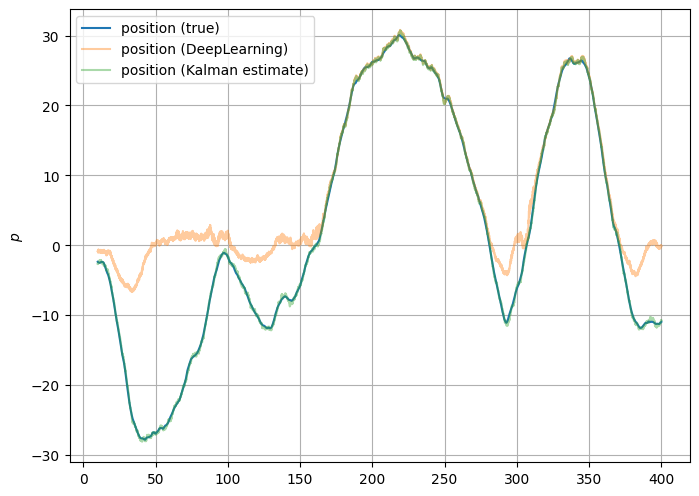

In [29]:
n=200
##########            칼만 생성            ##########
sigma_w = B_test@B_test.T
sigma_v = 1
hat_x = np.zeros((2,N_test))
hat_x[:,0] = np.array([0,0])
sigma = np.eye(2)*10
for t in range(N_test-1):
    K = A_test@sigma@C_test.T@np.linalg.inv(C_test@sigma@C_test.T+sigma_v)
    hat_x[:,t+1] = A_test@hat_x[:,t] + K@(y_test[0,t] - C_test@hat_x[:,t])
    sigma = A_test@sigma@A_test.T - K@C_test@sigma@A_test.T+sigma_w


##########            딥러닝 생성            ##########
test = []
for i in range(len(y_test[0])-n):
    test.append(y_test[0,i:i+n].reshape(n,-1))
x_test_ready_200_multilayer = np.array(test).reshape(-1,n)
y_test_ready_200_multilayer = x_test[0,n:-1]
position_hat = model_200_multilayer.predict(x_test_ready_200_multilayer)


##########            n개 평균 생성            ##########
temp = []
for i in range(len(y_test[0])-n):
    avg = 0
    for j in range(i,i+n):
        avg+=y_test[0,j]
    temp.append(avg/n)
y_n = np.array(temp)
##########            시각화            ##########

plt.figure(figsize=(8,6), dpi=100)
plt.plot(ts_test[n:-1],x_test[0,n:-1], label='position (true)')
plt.plot(ts_test[n:-1],position_hat[:], alpha=0.4, label='position (DeepLearning)')
plt.plot(ts_test[n:-1],hat_x[0,n:],alpha = 0.4, label='position (Kalman estimate)')
#plt.plot(ts_test[n:-1],y_n[:],alpha = 0.2, label='position (n_average)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
Kalman_RMSE = 0
DeepLearning_RMSE = 0
for k in range(len(y_test[0])-n):
    Kalman_RMSE += (x_test[0,n:-1][k]-hat_x[0,n:][k])**2
    DeepLearning_RMSE += (x_test[0,n:-1][k]-position_hat[k])**2
Kalman_RMSE = (Kalman_RMSE/(len(y_test[0])-n))**0.5
DeepLearning_RMSE = (DeepLearning_RMSE/(len(y_test[0])-n))**0.5
Kalman_RMSE_list_G.append(Kalman_RMSE)
DeepLearning_RMSE_list_G.append(DeepLearning_RMSE[0])
print('               n  : ',n)
print('      Kalman_RMSE : ',Kalman_RMSE)
print('DeepLearning_RMSE : ',DeepLearning_RMSE[0])

##### Noise가 가우시안 분포를 따를떄의 결과 정리

In [71]:
more = []
for c in range(len(Kalman_RMSE_list_G)):
    if Kalman_RMSE_list_G[c]>DeepLearning_RMSE_list_G[c]:
        more.append('DeepLearning Good')
    else :
        more.append('KalmanFilter Good')
result_dic = {
    'N':[2,4,10,20,50,200,2,4,10,20,50,200],
    'Kalman RMSE':Kalman_RMSE_list_G,
    'DeepLearning RMSE':DeepLearning_RMSE_list_G,
    'Better':more
}
df_G = pd.DataFrame(result_dic,index=['None hidden layer','None hidden layer','None hidden layer','None hidden layer','None hidden layer','None hidden layer','Hidden layer','Hidden layer','Hidden layer','Hidden layer','Hidden layer','Hidden layer'])
print("Best case DeepLearning")
print(df_G.iloc[DeepLearning_RMSE_list_G.index(min(DeepLearning_RMSE_list_G))])
df_G

Best case DeepLearning
N                             200
Kalman                   0.267207
DeepLearning             0.283516
Better          KalmanFilter Good
Name: None hidden layer, dtype: object


,N,Kalman,DeepLearning,Better
None hidden layer,2,0.267955,0.724641,KalmanFilter Good
None hidden layer,4,0.267921,0.523848,KalmanFilter Good
None hidden layer,10,0.266978,0.376809,KalmanFilter Good
None hidden layer,20,0.265896,0.372523,KalmanFilter Good
None hidden layer,50,0.266137,0.294029,KalmanFilter Good
None hidden layer,200,0.267207,0.283516,KalmanFilter Good
Hidden layer,2,0.267955,9.779609,KalmanFilter Good
Hidden layer,4,0.267921,10.599646,KalmanFilter Good
Hidden layer,10,0.266978,8.363823,KalmanFilter Good
Hidden layer,20,0.265896,5.524909,KalmanFilter Good


hidden layer가 없을경우 N이 커지면 RMSE가 줄어드는 경향을 보인다. N이 200까지 커졌을 경우 칼만필터와 딥러닝의 RMSE값은 거의 차이가 없다. 그러나 hidden layer을 추가하여 훈련을 시켰을 경우는 RMSE가 많이 증가했으므로 성능이 나빠졌다고 볼수있다.

이로 얻을 수 있는 결과는 noise를 확실히 알고있고 그 값들이 가우시안 분포를 따른다면 칼만 필터가 조금 더 정확한 것이다.
밑에서는 noise를 가우시안 분포를 따르지 않는 값들로 바꾸고 위와 같은 과정을 다시한번 실행시킬 것이다.

# 노이즈를 바꿈 

##### 노이즈를 가우시안 분포를 따르지 않게끔 바꿨을때 딥러닝과 칼만필터를 비교

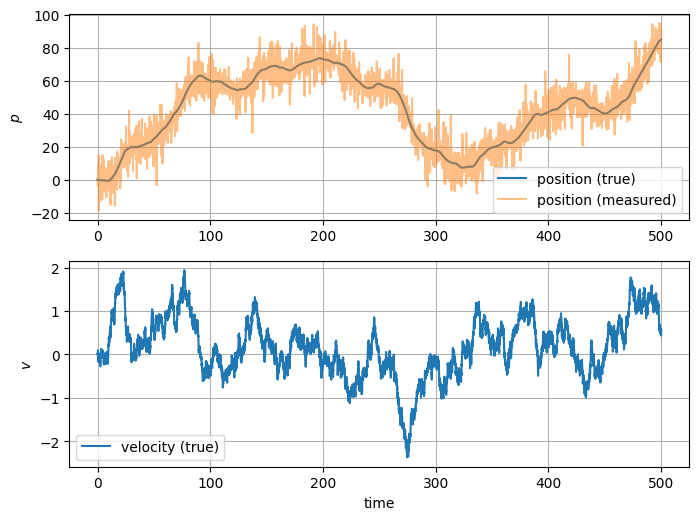

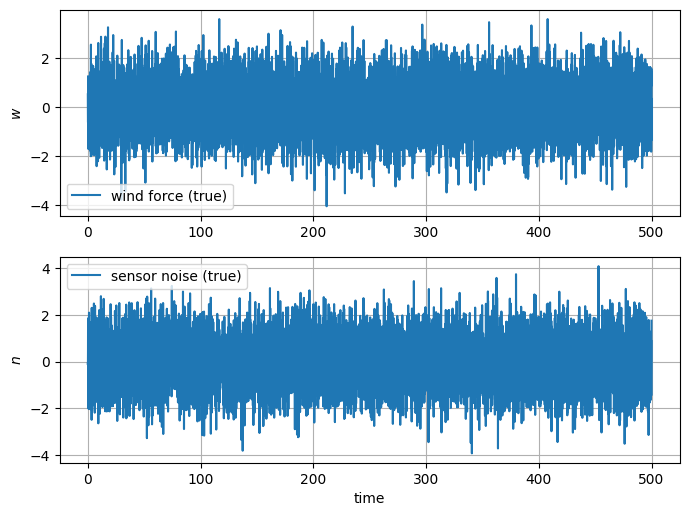

In [31]:
N = 10000 # number of timesteps
T = 500 # time will vary from 0 to T with step delt
ts = np.linspace(0,T,N+1)
delt = T/N
gamma = .05 # damping, 0 is no damping

A = np.zeros((2,2))
B = np.zeros((2,1))
C = np.zeros((1,2))

A[0,0] = 1
A[0,1] = (1-gamma*delt/2)*delt
A[1,1] = 1 - gamma*delt

B[0,0] = delt**2/269
B[1,0] = delt

C[0,0] = 1

np.random.seed(seed)

x = np.zeros((2,N+1))
x[:,0] = [0,0]
y = np.zeros((1,N))

w = np.random.randn(1,N)
n = np.random.randn(1,N)

for t in range(N):
    switch = np.random.randint(0,10)
    if switch==7 or switch==3 or switch==5 or switch==0:
        var = np.random.randint(0,10)
    else:
        var=0
    y[:,t] = C.dot(x[:,t]) + var*n[:,t]
    x[:,t+1] = A.dot(x[:,t]) + B.dot(w[:,t])
    
    
x_true = x.copy()
w_true = w.copy()
n_true = n.copy()

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts,x[0,:], label='position (true)')
plt.plot(ts[:-1],y[0,:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts[:-1],w_true[0,:], label='wind force (true)')
plt.ylabel(r"$w$")
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts[:-1],n_true[0,:], label='sensor noise (true)')
plt.xlabel('time')
plt.ylabel(r'$n$')
plt.legend()
plt.grid()
plt.show()

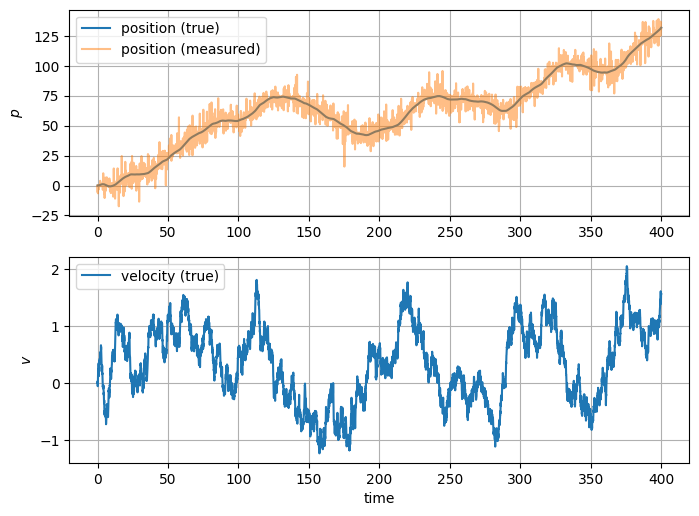

In [32]:
N_test = 8000 # number of timesteps
T_test = 400 # time will vary from 0 to T with step delt
ts_test = np.linspace(0,T_test,N_test+1)
delt_test = T_test/N_test
gamma_test = .05 # damping, 0 is no damping

A_test = np.zeros((2,2))
B_test= np.zeros((2,1))
C_test = np.zeros((1,2))

A_test[0,0] = 1
A_test[0,1] = (1-gamma_test*delt_test/2)*delt_test
A_test[1,1] = 1 - gamma_test*delt_test

B_test[0,0] = delt_test**2/269
B_test[1,0] = delt_test

C_test[0,0] = 1


x_test = np.zeros((2,N_test+1))
x_test[:,0] = [0,0]
y_test = np.zeros((1,N_test))

w_test = np.random.randn(1,N_test)
n_test = np.random.randn(1,N_test)

for t in range(N_test):
    switch = np.random.randint(0,10)
    if switch==7 or switch==3 or switch==5:
        var = np.random.randint(0,10)
    else:
        var=0
    y_test[:,t] = C_test.dot(x_test[:,t]) + var*n_test[:,t]
    x_test[:,t+1] = A_test.dot(x_test[:,t]) + B_test.dot(w_test[:,t])
    
plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts_test,x_test[0,:], label='position (true)')
plt.plot(ts_test[:-1],y_test[0,:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts_test,x_test[1,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()


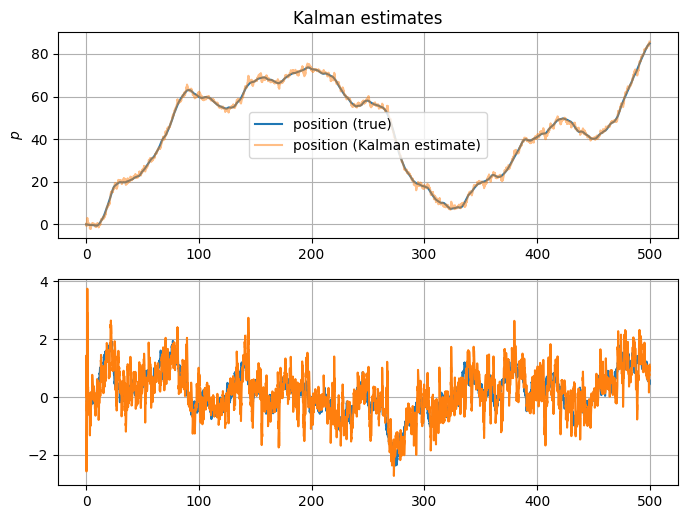

In [33]:
sigma_w = B@B.T
sigma_v = 1
hat_x = np.zeros((2,N))
hat_x[:,0] = np.array([0,0])
sigma = np.eye(2)*10

x_train = np.zeros((2,N))
y_train = np.zeros((2,N))

for t in range(N-1):
    K = A@sigma@C.T@np.linalg.inv(C@sigma@C.T+sigma_v)
    hat_x[:,t+1] = A@hat_x[:,t] + K@(y[0,t] - C@hat_x[:,t])
    sigma = A@sigma@A.T - K@C@sigma@A.T+sigma_w
    x_train[:,t] = (y[0,t] - C@hat_x[:,t])
    y_train[:,t] = hat_x[:,t+1]-A@hat_x[:,t]
x_train = x_train.reshape(-1,2)
y_train = y_train.reshape(-1,2)


plt.figure(figsize = (8,6),dpi=100)
plt.subplot(2,1,1)
plt.plot(ts,x[0,:],label='position (true)')
plt.plot(ts[:-1],hat_x[0,:],alpha = 0.5, label='position (Kalman estimate)')
plt.ylabel(r'$p$')
plt.title('Kalman estimates')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts,x[1,:],label='velocity (true)')
plt.plot(ts[:-1],hat_x[1,:],alpha=1,label='velocity (Kalman estimates)')
plt.grid()

# N=2

In [34]:
n=2
temp = []
for i in range(len(y[0])-n):
    temp.append(y[0,i:i+n].reshape(n,-1))
x_train = np.array(temp).reshape(-1,n)
y_train = x[0,n:-1]
model_2 = Sequential()
model_2.add(Dense(1,input_dim = n))
model_2.compile(loss = 'mse',optimizer = 'adam',metrics = ['accuracy'])
history = model_2.fit(x_train,y_train,epochs = epochs,verbose = 0,batch_size=batch_size)
position_hat = model_2.predict(x_train)

#plt.figure(figsize=(8,6), dpi=100)
#plt.plot(ts[n:-1],x[0,n:-1], label='position (true)')
#plt.plot(ts[n:-1],position_hat[:], alpha=0.5, label='position (measured)')
#plt.ylabel(r'$p$')
#plt.legend()
#plt.grid()

               n  :  2
      Kalman_RMSE :  0.7741489532393138
DeepLearning_RMSE :  2.2209432


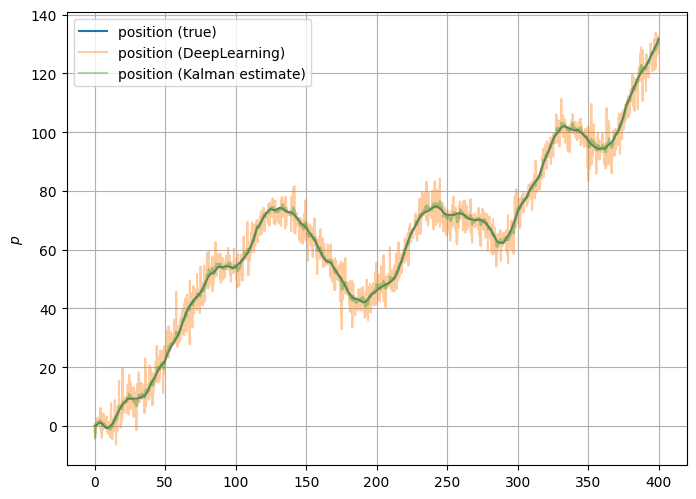

In [35]:
n=2
##########            칼만 생성            ##########
sigma_w = B_test@B_test.T
sigma_v = 1
hat_x = np.zeros((2,N_test))
hat_x[:,0] = np.array([0,0])
sigma = np.eye(2)*10
for t in range(N_test-1):
    K = A_test@sigma@C_test.T@np.linalg.inv(C_test@sigma@C_test.T+sigma_v)
    hat_x[:,t+1] = A_test@hat_x[:,t] + K@(y_test[0,t] - C_test@hat_x[:,t])
    sigma = A_test@sigma@A_test.T - K@C_test@sigma@A_test.T+sigma_w


##########            딥러닝 생성            ##########
test = []
for i in range(len(y_test[0])-n):
    test.append(y_test[0,i:i+n].reshape(n,-1))
x_test_ready_2 = np.array(test).reshape(-1,n)
y_test_ready_2 = x_test[0,n:-1]
position_hat = model_2.predict(x_test_ready_2)


##########            n개 평균 생성            ##########
temp = []
for i in range(len(y_test[0])-n):
    avg = 0
    for j in range(i,i+n):
        avg+=y_test[0,j]
    temp.append(avg/n)
y_n = np.array(temp)
##########            시각화            ##########

plt.figure(figsize=(8,6), dpi=100)
plt.plot(ts_test[n:-1],x_test[0,n:-1], label='position (true)')
plt.plot(ts_test[n:-1],position_hat[:], alpha=0.4, label='position (DeepLearning)')
plt.plot(ts_test[n:-1],hat_x[0,n:],alpha = 0.4, label='position (Kalman estimate)')
#plt.plot(ts_test[n:-1],y_n[:],alpha = 0.3, label='position (n_average)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

Kalman_RMSE = 0
DeepLearning_RMSE = 0
for k in range(len(y_test[0])-n):
    Kalman_RMSE += (x_test[0,n:-1][k]-hat_x[0,n:][k])**2
    DeepLearning_RMSE += (x_test[0,n:-1][k]-position_hat[k])**2
Kalman_RMSE = (Kalman_RMSE/(len(y_test[0])-n))**0.5
DeepLearning_RMSE = (DeepLearning_RMSE/(len(y_test[0])-n))**0.5
Kalman_RMSE_list_N.append(Kalman_RMSE)
DeepLearning_RMSE_list_N.append(DeepLearning_RMSE[0])
print('               n  : ',n)
print('      Kalman_RMSE : ',Kalman_RMSE)
print('DeepLearning_RMSE : ',DeepLearning_RMSE[0])


# N=4

In [36]:
n=4
temp = []
for i in range(len(y[0])-n):
    temp.append(y[0,i:i+n].reshape(n,-1))
x_train = np.array(temp).reshape(-1,n)
y_train = x[0,n:-1]
model_4 = Sequential()
model_4.add(Dense(1,input_dim = n))
model_4.compile(loss = 'mse',optimizer = 'adam',metrics = ['accuracy'])
history = model_4.fit(x_train,y_train,epochs = epochs,verbose = 0,batch_size=batch_size)
position_hat = model_4.predict(x_train)

#plt.figure(figsize=(8,6), dpi=100)
#plt.plot(ts[n:-1],x[0,n:-1], label='position (true)')
#plt.plot(ts[n:-1],position_hat[:], alpha=0.5, label='position (measured)')
#plt.ylabel(r'$p$')
#plt.legend()
#plt.grid()

               n  :  4
      Kalman_RMSE :  0.7738850606295836
DeepLearning_RMSE :  1.5842541


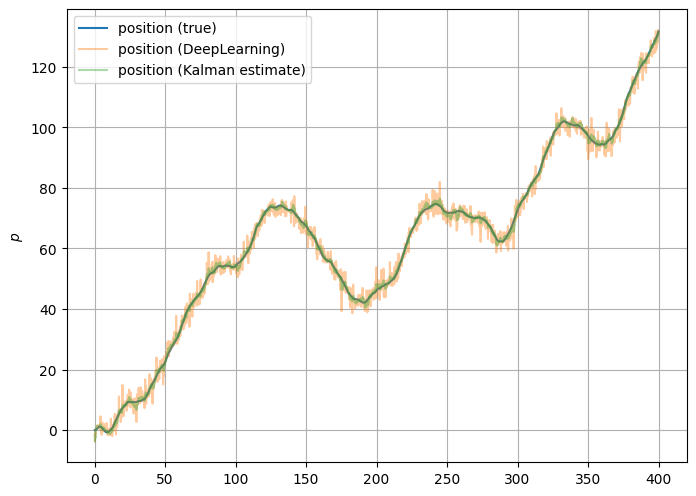

In [37]:
n=4
##########            칼만 생성            ##########
sigma_w = B_test@B_test.T
sigma_v = 1
hat_x = np.zeros((2,N_test))
hat_x[:,0] = np.array([0,0])
sigma = np.eye(2)*10
for t in range(N_test-1):
    K = A_test@sigma@C_test.T@np.linalg.inv(C_test@sigma@C_test.T+sigma_v)
    hat_x[:,t+1] = A_test@hat_x[:,t] + K@(y_test[0,t] - C_test@hat_x[:,t])
    sigma = A_test@sigma@A_test.T - K@C_test@sigma@A_test.T+sigma_w


##########            딥러닝 생성            ##########
test = []
for i in range(len(y_test[0])-n):
    test.append(y_test[0,i:i+n].reshape(n,-1))
x_test_ready_4 = np.array(test).reshape(-1,n)
y_test_ready_4 = x_test[0,n:-1]
position_hat = model_4.predict(x_test_ready_4)


##########            n개 평균 생성            ##########
temp = []
for i in range(len(y_test[0])-n):
    avg = 0
    for j in range(i,i+n):
        avg+=y_test[0,j]
    temp.append(avg/n)
y_n = np.array(temp)
##########            시각화            ##########
plt.figure(figsize=(8,6), dpi=100)
plt.plot(ts_test[n:-1],x_test[0,n:-1], label='position (true)')
plt.plot(ts_test[n:-1],position_hat[:], alpha=0.4, label='position (DeepLearning)')
plt.plot(ts_test[n:-1],hat_x[0,n:],alpha = 0.4, label='position (Kalman estimate)')
#plt.plot(ts_test[n:-1],y_n[:],alpha = 0.2, label='position (n_average)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

Kalman_RMSE = 0
DeepLearning_RMSE = 0
for k in range(len(y_test[0])-n):
    Kalman_RMSE += (x_test[0,n:-1][k]-hat_x[0,n:][k])**2
    DeepLearning_RMSE += (x_test[0,n:-1][k]-position_hat[k])**2
Kalman_RMSE = (Kalman_RMSE/(len(y_test[0])-n))**0.5
DeepLearning_RMSE = (DeepLearning_RMSE/(len(y_test[0])-n))**0.5
Kalman_RMSE_list_N.append(Kalman_RMSE)
DeepLearning_RMSE_list_N.append(DeepLearning_RMSE[0])
print('               n  : ',n)
print('      Kalman_RMSE : ',Kalman_RMSE)
print('DeepLearning_RMSE : ',DeepLearning_RMSE[0])


# N=10

In [38]:
n=10
temp = []
for i in range(len(y[0])-n):
    temp.append(y[0,i:i+n].reshape(n,-1))
x_train = np.array(temp).reshape(-1,n)
y_train = x[0,n:-1]
model_10 = Sequential()
model_10.add(Dense(1,input_dim = n))
model_10.compile(loss = 'mse',optimizer = 'adam',metrics = ['accuracy'])
history = model_10.fit(x_train,y_train,epochs = epochs,verbose = 0,batch_size=batch_size)
position_hat = model_10.predict(x_train)

#plt.figure(figsize=(8,6), dpi=100)
#plt.plot(ts[n:-1],x[0,n:-1], label='position (true)')
#plt.plot(ts[n:-1],position_hat[:], alpha=0.5, label='position (measured)')
#plt.ylabel(r'$p$')
#plt.legend()
#plt.grid()

               n  :  10
      Kalman_RMSE :  0.7707016849824814
DeepLearning_RMSE :  1.0195707


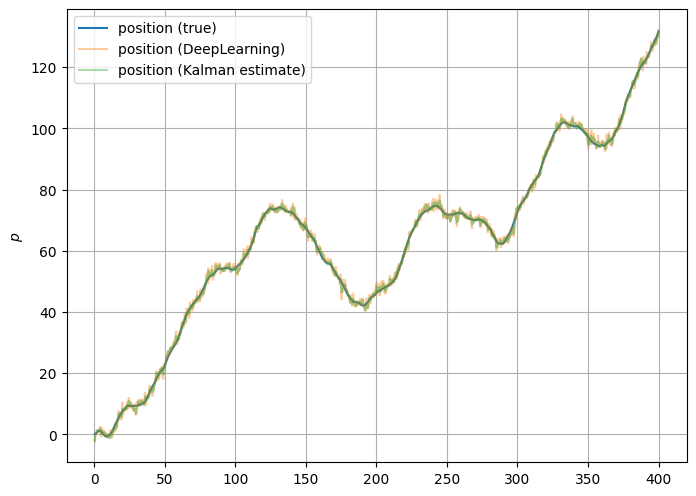

In [39]:
n=10
##########            칼만 생성            ##########
sigma_w = B_test@B_test.T
sigma_v = 1
hat_x = np.zeros((2,N_test))
hat_x[:,0] = np.array([0,0])
sigma = np.eye(2)*10
for t in range(N_test-1):
    K = A_test@sigma@C_test.T@np.linalg.inv(C_test@sigma@C_test.T+sigma_v)
    hat_x[:,t+1] = A_test@hat_x[:,t] + K@(y_test[0,t] - C_test@hat_x[:,t])
    sigma = A_test@sigma@A_test.T - K@C_test@sigma@A_test.T+sigma_w


##########            딥러닝 생성            ##########
test = []
for i in range(len(y_test[0])-n):
    test.append(y_test[0,i:i+n].reshape(n,-1))
x_test_ready_10 = np.array(test).reshape(-1,n)
y_test_ready_10 = x_test[0,n:-1]
position_hat = model_10.predict(x_test_ready_10)


##########            n개 평균 생성            ##########
temp = []
for i in range(len(y_test[0])-n):
    avg = 0
    for j in range(i,i+n):
        avg+=y_test[0,j]
    temp.append(avg/n)
y_n = np.array(temp)
##########            시각화            ##########

plt.figure(figsize=(8,6), dpi=100)
plt.plot(ts_test[n:-1],x_test[0,n:-1], label='position (true)')
plt.plot(ts_test[n:-1],position_hat[:], alpha=0.4, label='position (DeepLearning)')
plt.plot(ts_test[n:-1],hat_x[0,n:],alpha = 0.4, label='position (Kalman estimate)')
#plt.plot(ts_test[n:-1],y_n[:],alpha = 0.2, label='position (n_average)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

Kalman_RMSE = 0
DeepLearning_RMSE = 0
for k in range(len(y_test[0])-n):
    Kalman_RMSE += (x_test[0,n:-1][k]-hat_x[0,n:][k])**2
    DeepLearning_RMSE += (x_test[0,n:-1][k]-position_hat[k])**2
Kalman_RMSE = (Kalman_RMSE/(len(y_test[0])-n))**0.5
DeepLearning_RMSE = (DeepLearning_RMSE/(len(y_test[0])-n))**0.5
Kalman_RMSE_list_N.append(Kalman_RMSE)
DeepLearning_RMSE_list_N.append(DeepLearning_RMSE[0])
print('               n  : ',n)
print('      Kalman_RMSE : ',Kalman_RMSE)
print('DeepLearning_RMSE : ',DeepLearning_RMSE[0])

# N=20

In [40]:
n=20
temp = []
for i in range(len(y[0])-n):
    temp.append(y[0,i:i+n].reshape(n,-1))
x_train = np.array(temp).reshape(-1,n)
y_train = x[0,n:-1]
model_20 = Sequential()
model_20.add(Dense(1,input_dim = n))
model_20.compile(loss = 'mse',optimizer = 'adam',metrics = ['accuracy'])
history = model_20.fit(x_train,y_train,epochs = epochs,verbose = 0,batch_size=batch_size)
position_hat = model_20.predict(x_train)
#plt.figure(figsize=(8,6), dpi=100)
#plt.plot(ts[n:-1],x[0,n:-1], label='position (true)')
#plt.plot(ts[n:-1],position_hat[:], alpha=0.5, label='position (measured)')
#plt.ylabel(r'$p$')
#plt.legend()
#plt.grid()

               n  :  20
      Kalman_RMSE :  0.7697980068806478
DeepLearning_RMSE :  0.8954756


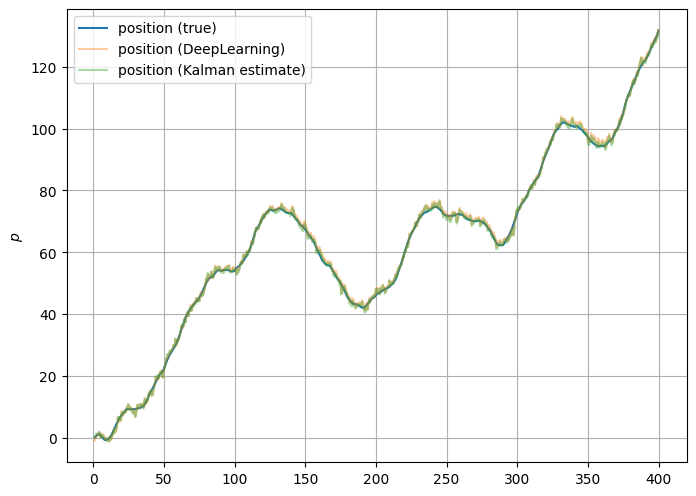

In [41]:
n=20
##########            칼만 생성            ##########
sigma_w = B_test@B_test.T
sigma_v = 1
hat_x = np.zeros((2,N_test))
hat_x[:,0] = np.array([0,0])
sigma = np.eye(2)*10
for t in range(N_test-1):
    K = A_test@sigma@C_test.T@np.linalg.inv(C_test@sigma@C_test.T+sigma_v)
    hat_x[:,t+1] = A_test@hat_x[:,t] + K@(y_test[0,t] - C_test@hat_x[:,t])
    sigma = A_test@sigma@A_test.T - K@C_test@sigma@A_test.T+sigma_w


##########            딥러닝 생성            ##########
test = []
for i in range(len(y_test[0])-n):
    test.append(y_test[0,i:i+n].reshape(n,-1))
x_test_ready_20 = np.array(test).reshape(-1,n)
y_test_ready_20 = x_test[0,n:-1]
position_hat = model_20.predict(x_test_ready_20)


##########            n개 평균 생성            ##########
temp = []
for i in range(len(y_test[0])-n):
    avg = 0
    for j in range(i,i+n):
        avg+=y_test[0,j]
    temp.append(avg/n)
y_n = np.array(temp)
##########            시각화            ##########

plt.figure(figsize=(8,6), dpi=100)
plt.plot(ts_test[n:-1],x_test[0,n:-1], label='position (true)')
plt.plot(ts_test[n:-1],position_hat[:], alpha=0.4, label='position (DeepLearning)')
plt.plot(ts_test[n:-1],hat_x[0,n:],alpha = 0.4, label='position (Kalman estimate)')
#plt.plot(ts_test[n:-1],y_n[:],alpha = 0.2, label='position (n_average)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

Kalman_RMSE = 0
DeepLearning_RMSE = 0
for k in range(len(y_test[0])-n):
    Kalman_RMSE += (x_test[0,n:-1][k]-hat_x[0,n:][k])**2
    DeepLearning_RMSE += (x_test[0,n:-1][k]-position_hat[k])**2
Kalman_RMSE = (Kalman_RMSE/(len(y_test[0])-n))**0.5
DeepLearning_RMSE = (DeepLearning_RMSE/(len(y_test[0])-n))**0.5
Kalman_RMSE_list_N.append(Kalman_RMSE)
DeepLearning_RMSE_list_N.append(DeepLearning_RMSE[0])
print('               n  : ',n)
print('      Kalman_RMSE : ',Kalman_RMSE)
print('DeepLearning_RMSE : ',DeepLearning_RMSE[0])

# N=50

In [42]:
n=50
temp = []
for i in range(len(y[0])-n):
    temp.append(y[0,i:i+n].reshape(n,-1))
x_train = np.array(temp).reshape(-1,n)
y_train = x[0,n:-1]
model_50 = Sequential()
model_50.add(Dense(1,input_dim = n))
model_50.compile(loss = 'mse',optimizer = 'adam',metrics = ['accuracy'])
history = model_50.fit(x_train,y_train,epochs = epochs,verbose = 0,batch_size=batch_size)
position_hat = model_50.predict(x_train)

#plt.figure(figsize=(8,6), dpi=100)
#plt.plot(ts[n:-1],x[0,n:-1], label='position (true)')
#plt.plot(ts[n:-1],position_hat[:], alpha=0.5, label='position (measured)')
#plt.ylabel(r'$p$')
#plt.legend()
#plt.grid()

               n  :  50
      Kalman_RMSE :  0.7703695416337665
DeepLearning_RMSE :  1.0192978


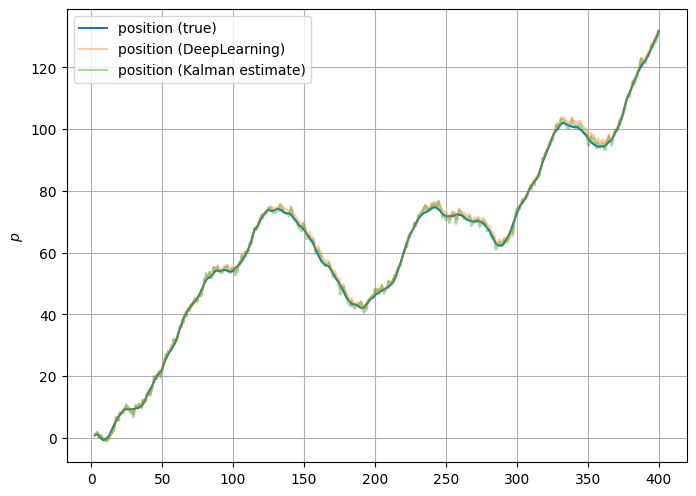

In [43]:
n=50
##########            칼만 생성            ##########
sigma_w = B_test@B_test.T
sigma_v = 1
hat_x = np.zeros((2,N_test))
hat_x[:,0] = np.array([0,0])
sigma = np.eye(2)*10
for t in range(N_test-1):
    K = A_test@sigma@C_test.T@np.linalg.inv(C_test@sigma@C_test.T+sigma_v)
    hat_x[:,t+1] = A_test@hat_x[:,t] + K@(y_test[0,t] - C_test@hat_x[:,t])
    sigma = A_test@sigma@A_test.T - K@C_test@sigma@A_test.T+sigma_w


##########            딥러닝 생성            ##########
test = []
for i in range(len(y_test[0])-n):
    test.append(y_test[0,i:i+n].reshape(n,-1))
x_test_ready_50 = np.array(test).reshape(-1,n)
y_test_ready_50 = x_test[0,n:-1]
position_hat = model_50.predict(x_test_ready_50)


##########            n개 평균 생성            ##########
temp = []
for i in range(len(y_test[0])-n):
    avg = 0
    for j in range(i,i+n):
        avg+=y_test[0,j]
    temp.append(avg/n)
y_n = np.array(temp)
##########            시각화            ##########

plt.figure(figsize=(8,6), dpi=100)
plt.plot(ts_test[n:-1],x_test[0,n:-1], label='position (true)')
plt.plot(ts_test[n:-1],position_hat[:], alpha=0.4, label='position (DeepLearning)')
plt.plot(ts_test[n:-1],hat_x[0,n:],alpha = 0.4, label='position (Kalman estimate)')
#plt.plot(ts_test[n:-1],y_n[:],alpha = 0.2, label='position (n_average)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

Kalman_RMSE = 0
DeepLearning_RMSE = 0
for k in range(len(y_test[0])-n):
    Kalman_RMSE += (x_test[0,n:-1][k]-hat_x[0,n:][k])**2
    DeepLearning_RMSE += (x_test[0,n:-1][k]-position_hat[k])**2
Kalman_RMSE = (Kalman_RMSE/(len(y_test[0])-n))**0.5
DeepLearning_RMSE = (DeepLearning_RMSE/(len(y_test[0])-n))**0.5
Kalman_RMSE_list_N.append(Kalman_RMSE)
DeepLearning_RMSE_list_N.append(DeepLearning_RMSE[0])
print('               n  : ',n)
print('      Kalman_RMSE : ',Kalman_RMSE)
print('DeepLearning_RMSE : ',DeepLearning_RMSE[0])


# n = 200

In [44]:
n=200
temp = []
for i in range(len(y[0])-n):
    temp.append(y[0,i:i+n].reshape(n,-1))
x_train = np.array(temp).reshape(-1,n)
y_train = x[0,n:-1]
model_200 = Sequential()
model_200.add(Dense(1,input_dim = n))
model_200.compile(loss = 'mse',optimizer = 'adam',metrics = ['accuracy'])
history = model_200.fit(x_train,y_train,epochs = epochs,verbose = 0,batch_size=batch_size)
position_hat = model_200.predict(x_train)

#plt.figure(figsize=(8,6), dpi=100)
#plt.plot(ts[n:-1],x[0,n:-1], label='position (true)')
#plt.plot(ts[n:-1],position_hat[:], alpha=0.5, label='position (measured)')
#plt.ylabel(r'$p$')
#plt.legend()
#plt.grid()

               n  :  200
      Kalman_RMSE :  0.7753830088987711
DeepLearning_RMSE :  1.2862611


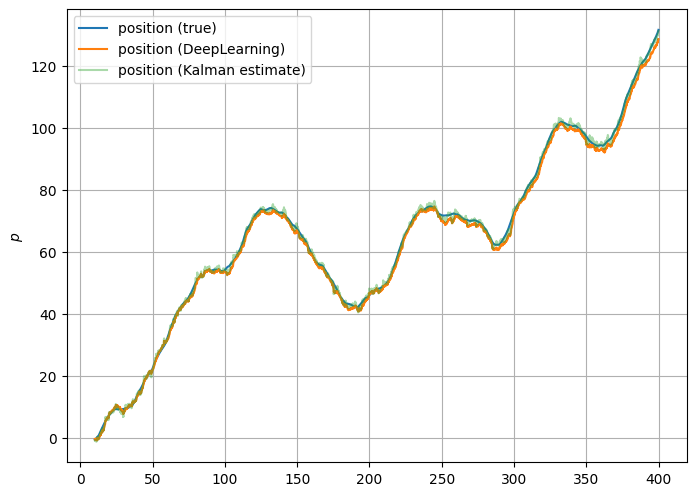

In [45]:
n=200
##########            칼만 생성            ##########
sigma_w = B_test@B_test.T
sigma_v = 1
hat_x = np.zeros((2,N_test))
hat_x[:,0] = np.array([0,0])
sigma = np.eye(2)*10
for t in range(N_test-1):
    K = A_test@sigma@C_test.T@np.linalg.inv(C_test@sigma@C_test.T+sigma_v)
    hat_x[:,t+1] = A_test@hat_x[:,t] + K@(y_test[0,t] - C_test@hat_x[:,t])
    sigma = A_test@sigma@A_test.T - K@C_test@sigma@A_test.T+sigma_w


##########            딥러닝 생성            ##########
test = []
for i in range(len(y_test[0])-n):
    test.append(y_test[0,i:i+n].reshape(n,-1))
x_test_ready_200 = np.array(test).reshape(-1,n)
y_test_ready_200 = x_test[0,n:-1]
position_hat = model_200.predict(x_test_ready_200)


##########            n개 평균 생성            ##########
temp = []
for i in range(len(y_test[0])-n):
    avg = 0
    for j in range(i,i+n):
        avg+=y_test[0,j]
    temp.append(avg/n)
y_n = np.array(temp)
##########            시각화            ##########

plt.figure(figsize=(8,6), dpi=100)
plt.plot(ts_test[n:-1],x_test[0,n:-1], label='position (true)')
plt.plot(ts_test[n:-1],position_hat[:], alpha=1, label='position (DeepLearning)')
plt.plot(ts_test[n:-1],hat_x[0,n:],alpha = 0.4, label='position (Kalman estimate)')
#plt.plot(ts_test[n:-1],y_n[:],alpha = 0.2, label='position (n_average)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

Kalman_RMSE = 0
DeepLearning_RMSE = 0
for k in range(len(y_test[0])-n):
    Kalman_RMSE += (x_test[0,n:-1][k]-hat_x[0,n:][k])**2
    DeepLearning_RMSE += (x_test[0,n:-1][k]-position_hat[k])**2
Kalman_RMSE = (Kalman_RMSE/(len(y_test[0])-n))**0.5
DeepLearning_RMSE = (DeepLearning_RMSE/(len(y_test[0])-n))**0.5
Kalman_RMSE_list_N.append(Kalman_RMSE)
DeepLearning_RMSE_list_N.append(DeepLearning_RMSE[0])
print('               n  : ',n)
print('      Kalman_RMSE : ',Kalman_RMSE)
print('DeepLearning_RMSE : ',DeepLearning_RMSE[0])


# 층수 +

# n=2

In [46]:
n=2
temp = []
for i in range(len(y[0])-n):
    temp.append(y[0,i:i+n].reshape(n,-1))
x_train = np.array(temp).reshape(-1,n)
y_train = x[0,n:-1]
model_2_multilayer = Sequential()
model_2_multilayer.add(Dense(50,input_dim = n,activation='relu'))
model_2_multilayer.add(Dense(25,activation='relu'))
model_2_multilayer.add(Dense(5,activation='relu'))
model_2_multilayer.add(Dense(1))
model_2_multilayer.compile(loss = 'mse',optimizer = 'adam',metrics = ['accuracy'])
history = model_2_multilayer.fit(x_train,y_train,epochs = epochs,verbose = 0,batch_size=batch_size)
position_hat = model_2_multilayer.predict(x_train)

#plt.figure(figsize=(8,6), dpi=100)
#plt.plot(ts[n:-1],x[0,n:-1], label='position (true)')
#plt.plot(ts[n:-1],position_hat[:], alpha=0.5, label='position (measured)')
#plt.ylabel(r'$p$')
#plt.legend()
#plt.grid()

               n  :  2
      Kalman_RMSE :  0.7741489532393138
DeepLearning_RMSE :  2.4692519


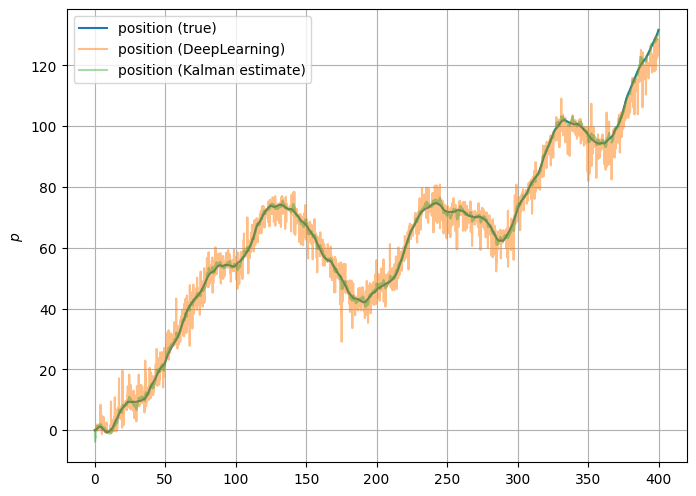

In [47]:
n=2
##########            칼만 생성            ##########
sigma_w = B_test@B_test.T
sigma_v = 1
hat_x = np.zeros((2,N_test))
hat_x[:,0] = np.array([0,0])
sigma = np.eye(2)*10
for t in range(N_test-1):
    K = A_test@sigma@C_test.T@np.linalg.inv(C_test@sigma@C_test.T+sigma_v)
    hat_x[:,t+1] = A_test@hat_x[:,t] + K@(y_test[0,t] - C_test@hat_x[:,t])
    sigma = A_test@sigma@A_test.T - K@C_test@sigma@A_test.T+sigma_w


##########            딥러닝 생성            ##########
test = []
for i in range(len(y_test[0])-n):
    test.append(y_test[0,i:i+n].reshape(n,-1))
x_test_ready_2_multilayer = np.array(test).reshape(-1,n)
y_test_ready_2_multilayer = x_test[0,n:-1]
position_hat = model_2_multilayer.predict(x_test_ready_2_multilayer)


##########            n개 평균 생성            ##########
temp = []
for i in range(len(y_test[0])-n):
    avg = 0
    for j in range(i,i+n):
        avg+=y_test[0,j]
    temp.append(avg/n)
y_n = np.array(temp)
##########            시각화            ##########

plt.figure(figsize=(8,6), dpi=100)
plt.plot(ts_test[n:-1],x_test[0,n:-1], label='position (true)')
plt.plot(ts_test[n:-1],position_hat[:], alpha=0.5, label='position (DeepLearning)')
plt.plot(ts_test[n:-1],hat_x[0,n:],alpha = 0.4, label='position (Kalman estimate)')
#plt.plot(ts_test[n:-1],y_n[:],alpha = 0.2, label='position (n_average)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

Kalman_RMSE = 0
DeepLearning_RMSE = 0
for k in range(len(y_test[0])-n):
    Kalman_RMSE += (x_test[0,n:-1][k]-hat_x[0,n:][k])**2
    DeepLearning_RMSE += (x_test[0,n:-1][k]-position_hat[k])**2
Kalman_RMSE = (Kalman_RMSE/(len(y_test[0])-n))**0.5
DeepLearning_RMSE = (DeepLearning_RMSE/(len(y_test[0])-n))**0.5
Kalman_RMSE_list_N.append(Kalman_RMSE)
DeepLearning_RMSE_list_N.append(DeepLearning_RMSE[0])
print('               n  : ',n)
print('      Kalman_RMSE : ',Kalman_RMSE)
print('DeepLearning_RMSE : ',DeepLearning_RMSE[0])

# n=4

In [48]:
n=4
temp = []
for i in range(len(y[0])-n):
    temp.append(y[0,i:i+n].reshape(n,-1))
x_train = np.array(temp).reshape(-1,n)
y_train = x[0,n:-1]
model_4_multilayer = Sequential()
model_4_multilayer.add(Dense(50,input_dim = n,activation='relu'))
model_4_multilayer.add(Dense(25,activation='relu'))
model_4_multilayer.add(Dense(5,activation='relu'))
model_4_multilayer.add(Dense(1))
model_4_multilayer.compile(loss = 'mse',optimizer = 'adam',metrics = ['accuracy'])
history = model_4_multilayer.fit(x_train,y_train,epochs = epochs,verbose = 0,batch_size=batch_size)
position_hat = model_4_multilayer.predict(x_train)

#plt.figure(figsize=(8,6), dpi=100)
#plt.plot(ts[n:-1],x[0,n:-1], label='position (true)')
#plt.plot(ts[n:-1],position_hat[:], alpha=0.5, label='position (measured)')
#plt.ylabel(r'$p$')
#plt.legend()
#plt.grid()

               n  :  4
      Kalman_RMSE :  0.7738850606295836
DeepLearning_RMSE :  0.8354241


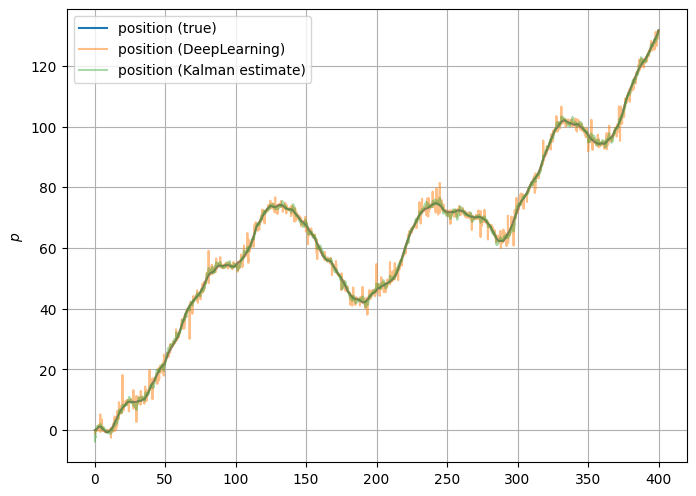

In [49]:
n=4
##########            칼만 생성            ##########
sigma_w = B_test@B_test.T
sigma_v = 1
hat_x = np.zeros((2,N_test))
hat_x[:,0] = np.array([0,0])
sigma = np.eye(2)*10
for t in range(N_test-1):
    K = A_test@sigma@C_test.T@np.linalg.inv(C_test@sigma@C_test.T+sigma_v)
    hat_x[:,t+1] = A_test@hat_x[:,t] + K@(y_test[0,t] - C_test@hat_x[:,t])
    sigma = A_test@sigma@A_test.T - K@C_test@sigma@A_test.T+sigma_w


##########            딥러닝 생성            ##########
test = []
for i in range(len(y_test[0])-n):
    test.append(y_test[0,i:i+n].reshape(n,-1))
x_test_ready_4_multilayer = np.array(test).reshape(-1,n)
y_test_ready_4_multilayer = x_test[0,n:-1]
position_hat = model_4_multilayer.predict(x_test_ready_4_multilayer)


##########            n개 평균 생성            ##########
temp = []
for i in range(len(y_test[0])-n):
    avg = 0
    for j in range(i,i+n):
        avg+=y_test[0,j]
    temp.append(avg/n)
y_n = np.array(temp)
##########            시각화            ##########

plt.figure(figsize=(8,6), dpi=100)
plt.plot(ts_test[n:-1],x_test[0,n:-1], label='position (true)')
plt.plot(ts_test[n:-1],position_hat[:], alpha=0.5, label='position (DeepLearning)')
plt.plot(ts_test[n:-1],hat_x[0,n:],alpha = 0.4, label='position (Kalman estimate)')
#plt.plot(ts_test[n:-1],y_n[:],alpha = 0.2, label='position (n_average)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

Kalman_RMSE = 0
DeepLearning_RMSE = 0
for k in range(len(y_test[0])-n):
    Kalman_RMSE += (x_test[0,n:-1][k]-hat_x[0,n:][k])**2
    DeepLearning_RMSE += (x_test[0,n:-1][k]-position_hat[k])**2
Kalman_RMSE = (Kalman_RMSE/(len(y_test[0])-n))**0.5
DeepLearning_RMSE = (DeepLearning_RMSE/(len(y_test[0])-n))**0.5
Kalman_RMSE_list_N.append(Kalman_RMSE)
DeepLearning_RMSE_list_N.append(DeepLearning_RMSE[0])
print('               n  : ',n)
print('      Kalman_RMSE : ',Kalman_RMSE)
print('DeepLearning_RMSE : ',DeepLearning_RMSE[0])

# n=10

In [50]:
n=10
temp = []
for i in range(len(y[0])-n):
    temp.append(y[0,i:i+n].reshape(n,-1))
x_train = np.array(temp).reshape(-1,n)
y_train = x[0,n:-1]
model_10_multilayer = Sequential()
model_10_multilayer.add(Dense(50,input_dim = n,activation='relu'))
model_10_multilayer.add(Dense(25,activation='relu'))
model_10_multilayer.add(Dense(5,activation='relu'))
model_10_multilayer.add(Dense(1))
model_10_multilayer.compile(loss = 'mse',optimizer = 'adam',metrics = ['accuracy'])
history = model_10_multilayer.fit(x_train,y_train,epochs = epochs,verbose = 0,batch_size=batch_size)
position_hat = model_10_multilayer.predict(x_train)

#plt.figure(figsize=(8,6), dpi=100)
#plt.plot(ts[n:-1],x[0,n:-1], label='position (true)')
#plt.plot(ts[n:-1],position_hat[:], alpha=0.5, label='position (measured)')
#plt.ylabel(r'$p$')
#plt.legend()
#plt.grid()

               n  :  10
      Kalman_RMSE :  0.7707016849824814
DeepLearning_RMSE :  0.5604397


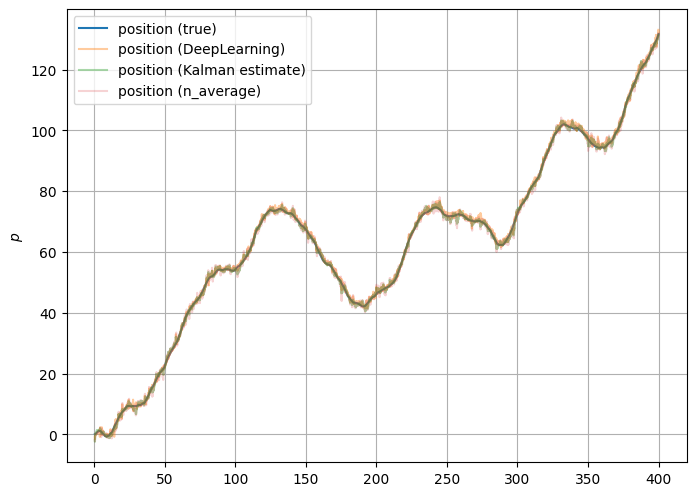

In [51]:
n=10
##########            칼만 생성            ##########
sigma_w = B_test@B_test.T
sigma_v = 1
hat_x = np.zeros((2,N_test))
hat_x[:,0] = np.array([0,0])
sigma = np.eye(2)*10
for t in range(N_test-1):
    K = A_test@sigma@C_test.T@np.linalg.inv(C_test@sigma@C_test.T+sigma_v)
    hat_x[:,t+1] = A_test@hat_x[:,t] + K@(y_test[0,t] - C_test@hat_x[:,t])
    sigma = A_test@sigma@A_test.T - K@C_test@sigma@A_test.T+sigma_w


##########            딥러닝 생성            ##########
test = []
for i in range(len(y_test[0])-n):
    test.append(y_test[0,i:i+n].reshape(n,-1))
x_test_ready_10_multilayer = np.array(test).reshape(-1,n)
y_test_ready_10_multilayer = x_test[0,n:-1]
position_hat = model_10_multilayer.predict(x_test_ready_10_multilayer)


##########            n개 평균 생성            ##########
temp = []
for i in range(len(y_test[0])-n):
    avg = 0
    for j in range(i,i+n):
        avg+=y_test[0,j]
    temp.append(avg/n)
y_n = np.array(temp)
##########            시각화            ##########

plt.figure(figsize=(8,6), dpi=100)
plt.plot(ts_test[n:-1],x_test[0,n:-1], label='position (true)')
plt.plot(ts_test[n:-1],position_hat[:], alpha=0.4, label='position (DeepLearning)')
plt.plot(ts_test[n:-1],hat_x[0,n:],alpha = 0.4, label='position (Kalman estimate)')
plt.plot(ts_test[n:-1],y_n[:],alpha = 0.2, label='position (n_average)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

Kalman_RMSE = 0
DeepLearning_RMSE = 0
for k in range(len(y_test[0])-n):
    Kalman_RMSE += (x_test[0,n:-1][k]-hat_x[0,n:][k])**2
    DeepLearning_RMSE += (x_test[0,n:-1][k]-position_hat[k])**2
Kalman_RMSE = (Kalman_RMSE/(len(y_test[0])-n))**0.5
DeepLearning_RMSE = (DeepLearning_RMSE/(len(y_test[0])-n))**0.5
Kalman_RMSE_list_N.append(Kalman_RMSE)
DeepLearning_RMSE_list_N.append(DeepLearning_RMSE[0])
print('               n  : ',n)
print('      Kalman_RMSE : ',Kalman_RMSE)
print('DeepLearning_RMSE : ',DeepLearning_RMSE[0])

# n=20

In [52]:
n=20
temp = []
for i in range(len(y[0])-n):
    temp.append(y[0,i:i+n].reshape(n,-1))
x_train = np.array(temp).reshape(-1,n)
y_train = x[0,n:-1]
model_20_multilayer = Sequential()
model_20_multilayer.add(Dense(50,input_dim = n,activation='relu'))
model_20_multilayer.add(Dense(25,activation='relu'))
model_20_multilayer.add(Dense(5,activation='relu'))
model_20_multilayer.add(Dense(1))
model_20_multilayer.compile(loss = 'mse',optimizer = 'adam',metrics = ['accuracy'])
history = model_20_multilayer.fit(x_train,y_train,epochs = epochs,verbose = 0,batch_size=batch_size)
position_hat = model_20_multilayer.predict(x_train)

#plt.figure(figsize=(8,6), dpi=100)
#plt.plot(ts[n:-1],x[0,n:-1], label='position (true)')
#plt.plot(ts[n:-1],position_hat[:], alpha=0.5, label='position (measured)')
#plt.ylabel(r'$p$')
#plt.legend()
#plt.grid()

               n  :  20
      Kalman_RMSE :  0.7697980068806478
DeepLearning_RMSE :  0.5933247


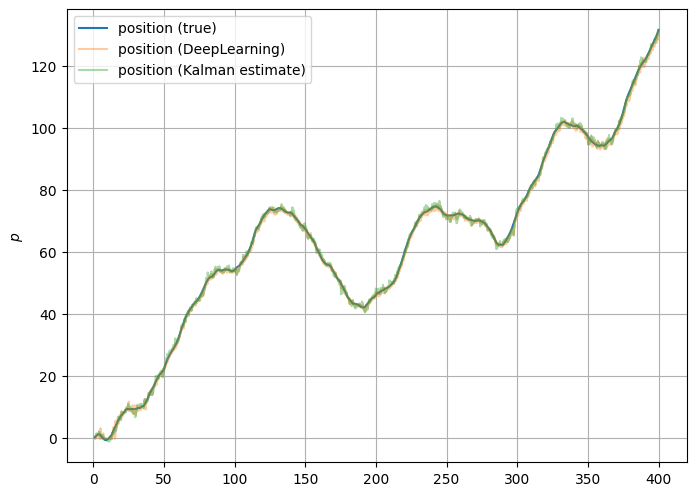

In [53]:
n=20
##########            칼만 생성            ##########
sigma_w = B_test@B_test.T
sigma_v = 1
hat_x = np.zeros((2,N_test))
hat_x[:,0] = np.array([0,0])
sigma = np.eye(2)*10
for t in range(N_test-1):
    K = A_test@sigma@C_test.T@np.linalg.inv(C_test@sigma@C_test.T+sigma_v)
    hat_x[:,t+1] = A_test@hat_x[:,t] + K@(y_test[0,t] - C_test@hat_x[:,t])
    sigma = A_test@sigma@A_test.T - K@C_test@sigma@A_test.T+sigma_w


##########            딥러닝 생성            ##########
test = []
for i in range(len(y_test[0])-n):
    test.append(y_test[0,i:i+n].reshape(n,-1))
x_test_ready_20_multilayer = np.array(test).reshape(-1,n)
y_test_ready_20_multilayer = x_test[0,n:-1]
position_hat = model_20_multilayer.predict(x_test_ready_20_multilayer)


##########            n개 평균 생성            ##########
temp = []
for i in range(len(y_test[0])-n):
    avg = 0
    for j in range(i,i+n):
        avg+=y_test[0,j]
    temp.append(avg/n)
y_n = np.array(temp)
##########            시각화            ##########

plt.figure(figsize=(8,6), dpi=100)
plt.plot(ts_test[n:-1],x_test[0,n:-1], label='position (true)')
plt.plot(ts_test[n:-1],position_hat[:], alpha=0.4, label='position (DeepLearning)')
plt.plot(ts_test[n:-1],hat_x[0,n:],alpha = 0.4, label='position (Kalman estimate)')
#plt.plot(ts_test[n:-1],y_n[:],alpha = 0.2, label='position (n_average)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

Kalman_RMSE = 0
DeepLearning_RMSE = 0
for k in range(len(y_test[0])-n):
    Kalman_RMSE += (x_test[0,n:-1][k]-hat_x[0,n:][k])**2
    DeepLearning_RMSE += (x_test[0,n:-1][k]-position_hat[k])**2
Kalman_RMSE = (Kalman_RMSE/(len(y_test[0])-n))**0.5
DeepLearning_RMSE = (DeepLearning_RMSE/(len(y_test[0])-n))**0.5
Kalman_RMSE_list_N.append(Kalman_RMSE)
DeepLearning_RMSE_list_N.append(DeepLearning_RMSE[0])
print('               n  : ',n)
print('      Kalman_RMSE : ',Kalman_RMSE)
print('DeepLearning_RMSE : ',DeepLearning_RMSE[0])

# n=50

In [54]:
n=50
temp = []
for i in range(len(y[0])-n):
    temp.append(y[0,i:i+n].reshape(n,-1))
x_train = np.array(temp).reshape(-1,n)
y_train = x[0,n:-1]
model_50_multilayer = Sequential()
model_50_multilayer.add(Dense(50,input_dim = n,activation='relu'))
model_50_multilayer.add(Dense(25,activation='relu'))
model_50_multilayer.add(Dense(5,activation='relu'))
model_50_multilayer.add(Dense(1))
model_50_multilayer.compile(loss = 'mse',optimizer = 'adam',metrics = ['accuracy'])
history = model_50_multilayer.fit(x_train,y_train,epochs = epochs,verbose = 0,batch_size=batch_size)
position_hat = model_50_multilayer.predict(x_train)

#plt.figure(figsize=(8,6), dpi=100)
#plt.plot(ts[n:-1],x[0,n:-1], label='position (true)')
#plt.plot(ts[n:-1],position_hat[:], alpha=0.5, label='position (measured)')
#plt.ylabel(r'$p$')
#plt.legend()
#plt.grid()


               n  :  50
      Kalman_RMSE :  0.7703695416337665
DeepLearning_RMSE :  0.72914755


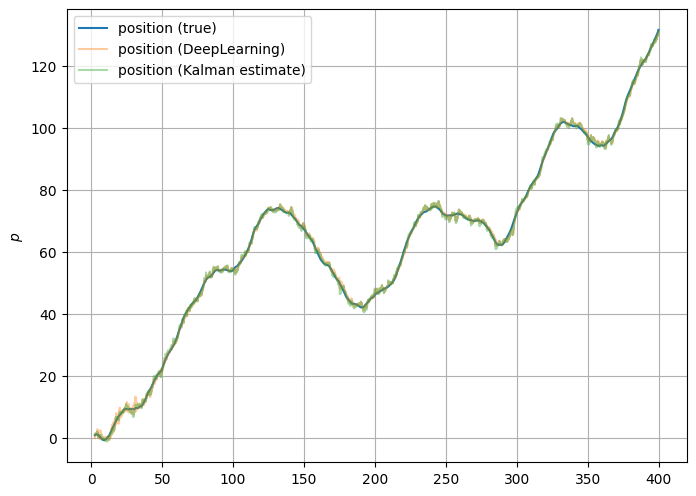

In [55]:
n=50
##########            칼만 생성            ##########
sigma_w = B_test@B_test.T
sigma_v = 1
hat_x = np.zeros((2,N_test))
hat_x[:,0] = np.array([0,0])
sigma = np.eye(2)*10
for t in range(N_test-1):
    K = A_test@sigma@C_test.T@np.linalg.inv(C_test@sigma@C_test.T+sigma_v)
    hat_x[:,t+1] = A_test@hat_x[:,t] + K@(y_test[0,t] - C_test@hat_x[:,t])
    sigma = A_test@sigma@A_test.T - K@C_test@sigma@A_test.T+sigma_w


##########            딥러닝 생성            ##########
test = []
for i in range(len(y_test[0])-n):
    test.append(y_test[0,i:i+n].reshape(n,-1))
x_test_ready_50_multilayer = np.array(test).reshape(-1,n)
y_test_ready_50_multilayer = x_test[0,n:-1]
position_hat = model_50_multilayer.predict(x_test_ready_50_multilayer)


##########            n개 평균 생성            ##########
temp = []
for i in range(len(y_test[0])-n):
    avg = 0
    for j in range(i,i+n):
        avg+=y_test[0,j]
    temp.append(avg/n)
y_n = np.array(temp)
##########            시각화            ##########

plt.figure(figsize=(8,6), dpi=100)
plt.plot(ts_test[n:-1],x_test[0,n:-1], label='position (true)')
plt.plot(ts_test[n:-1],position_hat[:], alpha=0.4, label='position (DeepLearning)')
plt.plot(ts_test[n:-1],hat_x[0,n:],alpha = 0.4, label='position (Kalman estimate)')
#plt.plot(ts_test[n:-1],y_n[:],alpha = 0.2, label='position (n_average)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
Kalman_RMSE = 0
DeepLearning_RMSE = 0
for k in range(len(y_test[0])-n):
    Kalman_RMSE += (x_test[0,n:-1][k]-hat_x[0,n:][k])**2
    DeepLearning_RMSE += (x_test[0,n:-1][k]-position_hat[k])**2
Kalman_RMSE = (Kalman_RMSE/(len(y_test[0])-n))**0.5
DeepLearning_RMSE = (DeepLearning_RMSE/(len(y_test[0])-n))**0.5
Kalman_RMSE_list_N.append(Kalman_RMSE)
DeepLearning_RMSE_list_N.append(DeepLearning_RMSE[0])
print('               n  : ',n)
print('      Kalman_RMSE : ',Kalman_RMSE)
print('DeepLearning_RMSE : ',DeepLearning_RMSE[0])


# n=200

In [56]:
n=200
temp = []
for i in range(len(y[0])-n):
    temp.append(y[0,i:i+n].reshape(n,-1))
x_train = np.array(temp).reshape(-1,n)
y_train = x[0,n:-1]
model_200_multilayer = Sequential()
model_200_multilayer.add(Dense(50,input_dim = n,activation='relu'))
model_200_multilayer.add(Dense(25,activation='relu'))
model_200_multilayer.add(Dense(5,activation='relu'))
model_200_multilayer.add(Dense(1))
model_200_multilayer.compile(loss = 'mse',optimizer = 'adam',metrics = ['accuracy'])
history = model_200_multilayer.fit(x_train,y_train,epochs = epochs,verbose = 0,batch_size=batch_size)
position_hat = model_200_multilayer.predict(x_train)

#plt.figure(figsize=(8,6), dpi=100)
#plt.plot(ts[n:-1],x[0,n:-1], label='position (true)')
#plt.plot(ts[n:-1],position_hat[:], alpha=0.5, label='position (measured)')
#plt.ylabel(r'$p$')
#plt.legend()
#plt.grid()

               n  :  200
      Kalman_RMSE :  0.7753830088987711
DeepLearning_RMSE :  0.7116122


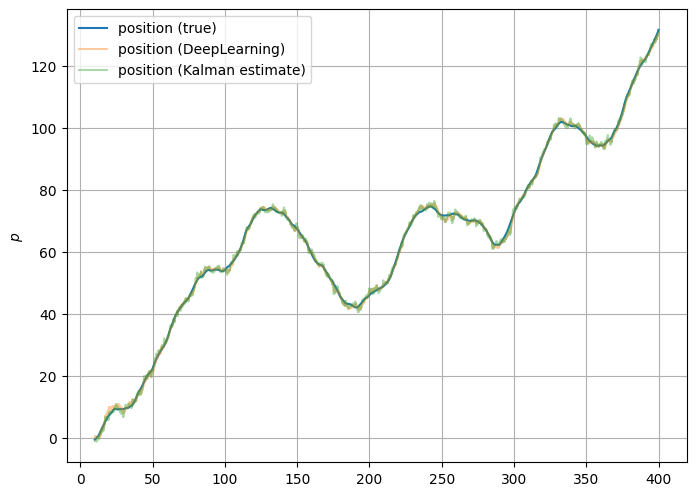

In [57]:
n=200
##########            칼만 생성            ##########
sigma_w = B_test@B_test.T
sigma_v = 1
hat_x = np.zeros((2,N_test))
hat_x[:,0] = np.array([0,0])
sigma = np.eye(2)*10
for t in range(N_test-1):
    K = A_test@sigma@C_test.T@np.linalg.inv(C_test@sigma@C_test.T+sigma_v)
    hat_x[:,t+1] = A_test@hat_x[:,t] + K@(y_test[0,t] - C_test@hat_x[:,t])
    sigma = A_test@sigma@A_test.T - K@C_test@sigma@A_test.T+sigma_w


##########            딥러닝 생성            ##########
test = []
for i in range(len(y_test[0])-n):
    test.append(y_test[0,i:i+n].reshape(n,-1))
x_test_ready_200_multilayer = np.array(test).reshape(-1,n)
y_test_ready_200_multilayer = x_test[0,n:-1]
position_hat = model_200_multilayer.predict(x_test_ready_200_multilayer)


##########            n개 평균 생성            ##########
temp = []
for i in range(len(y_test[0])-n):
    avg = 0
    for j in range(i,i+n):
        avg+=y_test[0,j]
    temp.append(avg/n)
y_n = np.array(temp)
##########            시각화            ##########

plt.figure(figsize=(8,6), dpi=100)
plt.plot(ts_test[n:-1],x_test[0,n:-1], label='position (true)')
plt.plot(ts_test[n:-1],position_hat[:], alpha=0.4, label='position (DeepLearning)')
plt.plot(ts_test[n:-1],hat_x[0,n:],alpha = 0.4, label='position (Kalman estimate)')
#plt.plot(ts_test[n:-1],y_n[:],alpha = 0.2, label='position (n_average)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
Kalman_RMSE = 0
DeepLearning_RMSE = 0
for k in range(len(y_test[0])-n):
    Kalman_RMSE += (x_test[0,n:-1][k]-hat_x[0,n:][k])**2
    DeepLearning_RMSE += (x_test[0,n:-1][k]-position_hat[k])**2
Kalman_RMSE = (Kalman_RMSE/(len(y_test[0])-n))**0.5
DeepLearning_RMSE = (DeepLearning_RMSE/(len(y_test[0])-n))**0.5
Kalman_RMSE_list_N.append(Kalman_RMSE)
DeepLearning_RMSE_list_N.append(DeepLearning_RMSE[0])
print('               n  : ',n)
print('      Kalman_RMSE : ',Kalman_RMSE)
print('DeepLearning_RMSE : ',DeepLearning_RMSE[0])

##### Noise가 가우시안 분포를 따르지 않을 떄 결과 정리

In [70]:
more = []
for c in range(len(Kalman_RMSE_list_N)):
    if Kalman_RMSE_list_N[c]>DeepLearning_RMSE_list_N[c]:
        more.append('DeepLearning Good')
    else :
        more.append('KalmanFilter Good')
result_dic = {
    'N':[2,4,10,20,50,200,2,4,10,20,50,200],
    'Kalman RMSE':Kalman_RMSE_list_N,
    'DeepLearning RMSE':DeepLearning_RMSE_list_N,
    'Better':more
}
df_N = pd.DataFrame(result_dic,index=['None hidden layer','None hidden layer','None hidden layer','None hidden layer','None hidden layer','None hidden layer','Hidden layer','Hidden layer','Hidden layer','Hidden layer','Hidden layer','Hidden layer'])
print("Best case DeepLearning")
print(df_N.iloc[DeepLearning_RMSE_list_N.index(min(DeepLearning_RMSE_list_N))])
df_N

Best case DeepLearning
N                              10
Kalman                   0.770702
DeepLearning              0.56044
Better          DeepLearning Good
Name: Hidden layer, dtype: object


,N,Kalman,DeepLearning,Better
None hidden layer,2,0.774149,2.220943,KalmanFilter Good
None hidden layer,4,0.773885,1.584254,KalmanFilter Good
None hidden layer,10,0.770702,1.019571,KalmanFilter Good
None hidden layer,20,0.769798,0.895476,KalmanFilter Good
None hidden layer,50,0.770370,1.019298,KalmanFilter Good
None hidden layer,200,0.775383,1.286261,KalmanFilter Good
Hidden layer,2,0.774149,2.469252,KalmanFilter Good
Hidden layer,4,0.773885,0.835424,KalmanFilter Good
Hidden layer,10,0.770702,0.560440,DeepLearning Good
Hidden layer,20,0.769798,0.593325,DeepLearning Good


위의 결과를 보면 위에서 실험한 결과들 보다 RMSE가 0.5정도 커졌다고 볼수있다.(가우시안 데이터셋과 non- 가우시안 데이터셋에서의칼만필터를 비교해보면) 확실히 칼만필터는 가우시안 분포를 따르지 않는 경우에는 예측이 덜 정확한 경향이 있다. 반면에 딥러닝으로 구현한 필터쪽을 살펴보면 hidden layer가 없는 경우들과 N이 작은 경우의 hidden layer가 있는경우에는 칼만필터보다 RMSE가 낮지만, 그 외의 경우에는 칼만필터보다 더 정확한 경향을 보였다. 

# 4.결과 요약

결과를 비교하여 볼 때 noise를 정확히 파악한 상태이고 그 noise가 가우시안 분포를 따른다는것을 알고 있는 상황이라면 굳이 
딥러닝을 이용하여 새로운 필터를 만드는 것은 의미없어 보인다. 그러나 포함되어있는 noise를 정확히 모르고 또한 알더라도 
가우시안 분포를 따르지 않는 경우에는 딥러닝으로 칼만필터를 구현하면 고전적인 칼만필터보다 더 정확한 값을 얻어내는 
것이 가능하다.